In [1]:
import numpy as np
import dill
import matplotlib.pyplot as plt
import matplotlib as mpl
import data_visualization as dv
from copy import deepcopy
import time
from pathlib import Path
import pandas as pd
from IPython.display import display
from scipy.stats import iqr

import read_data_functions as rdf
import plot_functions as pf
from Optimal_Stopping_Object import ModelConstructor
from initializer import InitialThangs
import Statistics as st
import loss_functions as lf
%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)

# Select Exp1 or Exp2


In [2]:
EXPERIMENT = "Exp1"

# Initial Thangs


In [3]:
plt.style.use("cashaback_dark")
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['font.size'] = 10
# mpl.rcParams['mathtext.fontset'] = 'custom'
# mpl.rcParams['mathtext.it'] = 'STIXGeneral:italic'
# mpl.rcParams['mathtext.bf'] = 'STIXGeneral:italic:bold'
# mpl.rcParams['mathtext.fontset'] = 'stix'

wheel = dv.ColorWheel()

# Get path and save path 
LOAD_PATH = Path(f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{EXPERIMENT}")
SAVE_PATH = Path(r"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures\scapps_talk")
it = InitialThangs(EXPERIMENT)

# Pickle Data and Models

In [4]:
if "group" not in locals():
    group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials", movement_metric_type='position')
else:
    if group.exp_info.experiment != EXPERIMENT:  # This means i changed experiment and need to run again
        group = rdf.generate_subject_object_v3(EXPERIMENT, "All Trials")
    
model_path = Path(f'D:\\OneDrive - University of Delaware - o365\\Desktop\\MatchPennies-Agent-Expirement\\results\\{EXPERIMENT}\\models')

model_description_dfs = list(model_path.glob(f"{EXPERIMENT}_model_descriptions*"))
model_parameter_dfs = list(model_path.glob(f"{EXPERIMENT}_model_parameters*"))
df_description = pd.read_pickle(model_description_dfs[-1])
df_params = pd.read_pickle(model_parameter_dfs[-1])
df_description['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)
df_params['Parameters'] = np.where(df_description.isin([False,'Less','Greater']),1,0).sum(axis=1)


In [5]:
print(np.array(df_params.query('Model == "model240_2023_09_18_13_51_02"')['timing_sd']))

[]


In [31]:
model_names_from_df = list(df_description.query('Parameters == 0 or (Known_Switch_SD==False and Known_Timing_SD==False and Known_Switch_Delay and Parameters==3)')['Model'])
base_model_df = df_params[df_params['Model'].isin(model_names_from_df)]
base_model_df = base_model_df.sort_values('Parameters')
model_names = ['Theoretical Optimal', 'Theoretical Optimal\n(Not Accounting for Switch Delay)', "Blah", "Blah"]
display(base_model_df)
models = {}
for i, (index, row) in enumerate(base_model_df.iterrows()):
    model  = ModelConstructor(
        experiment=EXPERIMENT,
        num_blocks=row.num_blocks,
        num_timesteps=1800,
        agent_means=row.agent_means,
        agent_sds=row.agent_sds, #!
        reaction_time=row.reaction_time,
        movement_time=row.movement_time,
        reaction_sd=row.reaction_sd, #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd=row.movement_sd,
        timing_sd=row.timing_sd,
        guess_switch_delay=row.guess_switch_delay, # Designed like this for broadcasting reasons
        guess_switch_sd=row.guess_switch_sd, # This includes electromechanical delay sd and timing sd bc it's straight from data
        # guess_sd=row.guess_sd,
        electromechanical_delay=row.electromechanical_delay,
        switch_cost_exists=True,
        expected=True,
        win_reward=row.win_reward,
        incorrect_cost=row.incorrect_cost,
        indecision_cost=row.indecision_cost,
        round_num = 23
    )
    print(model.inputs.guess_switch_sd)
    models.update({model_names[i]:model})

,Model,Loss,experiment,num_blocks,agent_means,agent_sds,nsteps,num_timesteps,round_num,expected,key,reaction_sd,movement_sd,timing_sd,guess_switch_sd,guess_sd,use_true_guess_sd,guess_sd_from_data,reaction_time,movement_time,guess_switch_delay,electromechanical_delay,guess_delay,win_reward,incorrect_cost,indecision_cost,prob_selecting_correct_target_reaction,prob_selecting_correct_target_guess,Parameters
4,model4_2023_09_26_15_25_09,10.821932,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,20,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[112]], [[112]]]","[[[135.69692872616992], [135.69692872616992], ...",False,False,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[68]], [[68]]]","[[[50]], [[50]]]","[[[118]], [[118]]]",1.0,0.0,0.0,1.0,0.5,1
1,model1_2023_09_26_15_24_39,7.296637,Exp1,6,"[[[999.306492462158], [1007.1201977157594], [1...","[[[48.76188568196375], [147.5029109578432], [4...",1,1800,20,True,1,"[[[37.69512147152565]], [[37.69512147152565]]]","[[[26.542679574365813]], [[26.542679574365813]]]","[[[76.61368327991575], [76.61368327991575], [7...","[[[120]], [[6]]]","[[[142.3715437358015], [142.3715437358015], [1...",False,False,"[[[241.25]], [[241.25]]]","[[[157.25]], [[157.25]]]","[[[82]], [[82]]]","[[[50]], [[50]]]","[[[132]], [[132]]]",1.0,0.0,0.0,1.0,0.5,2


[[[112]]

 [[112]]]
[[[120]]

 [[  6]]]


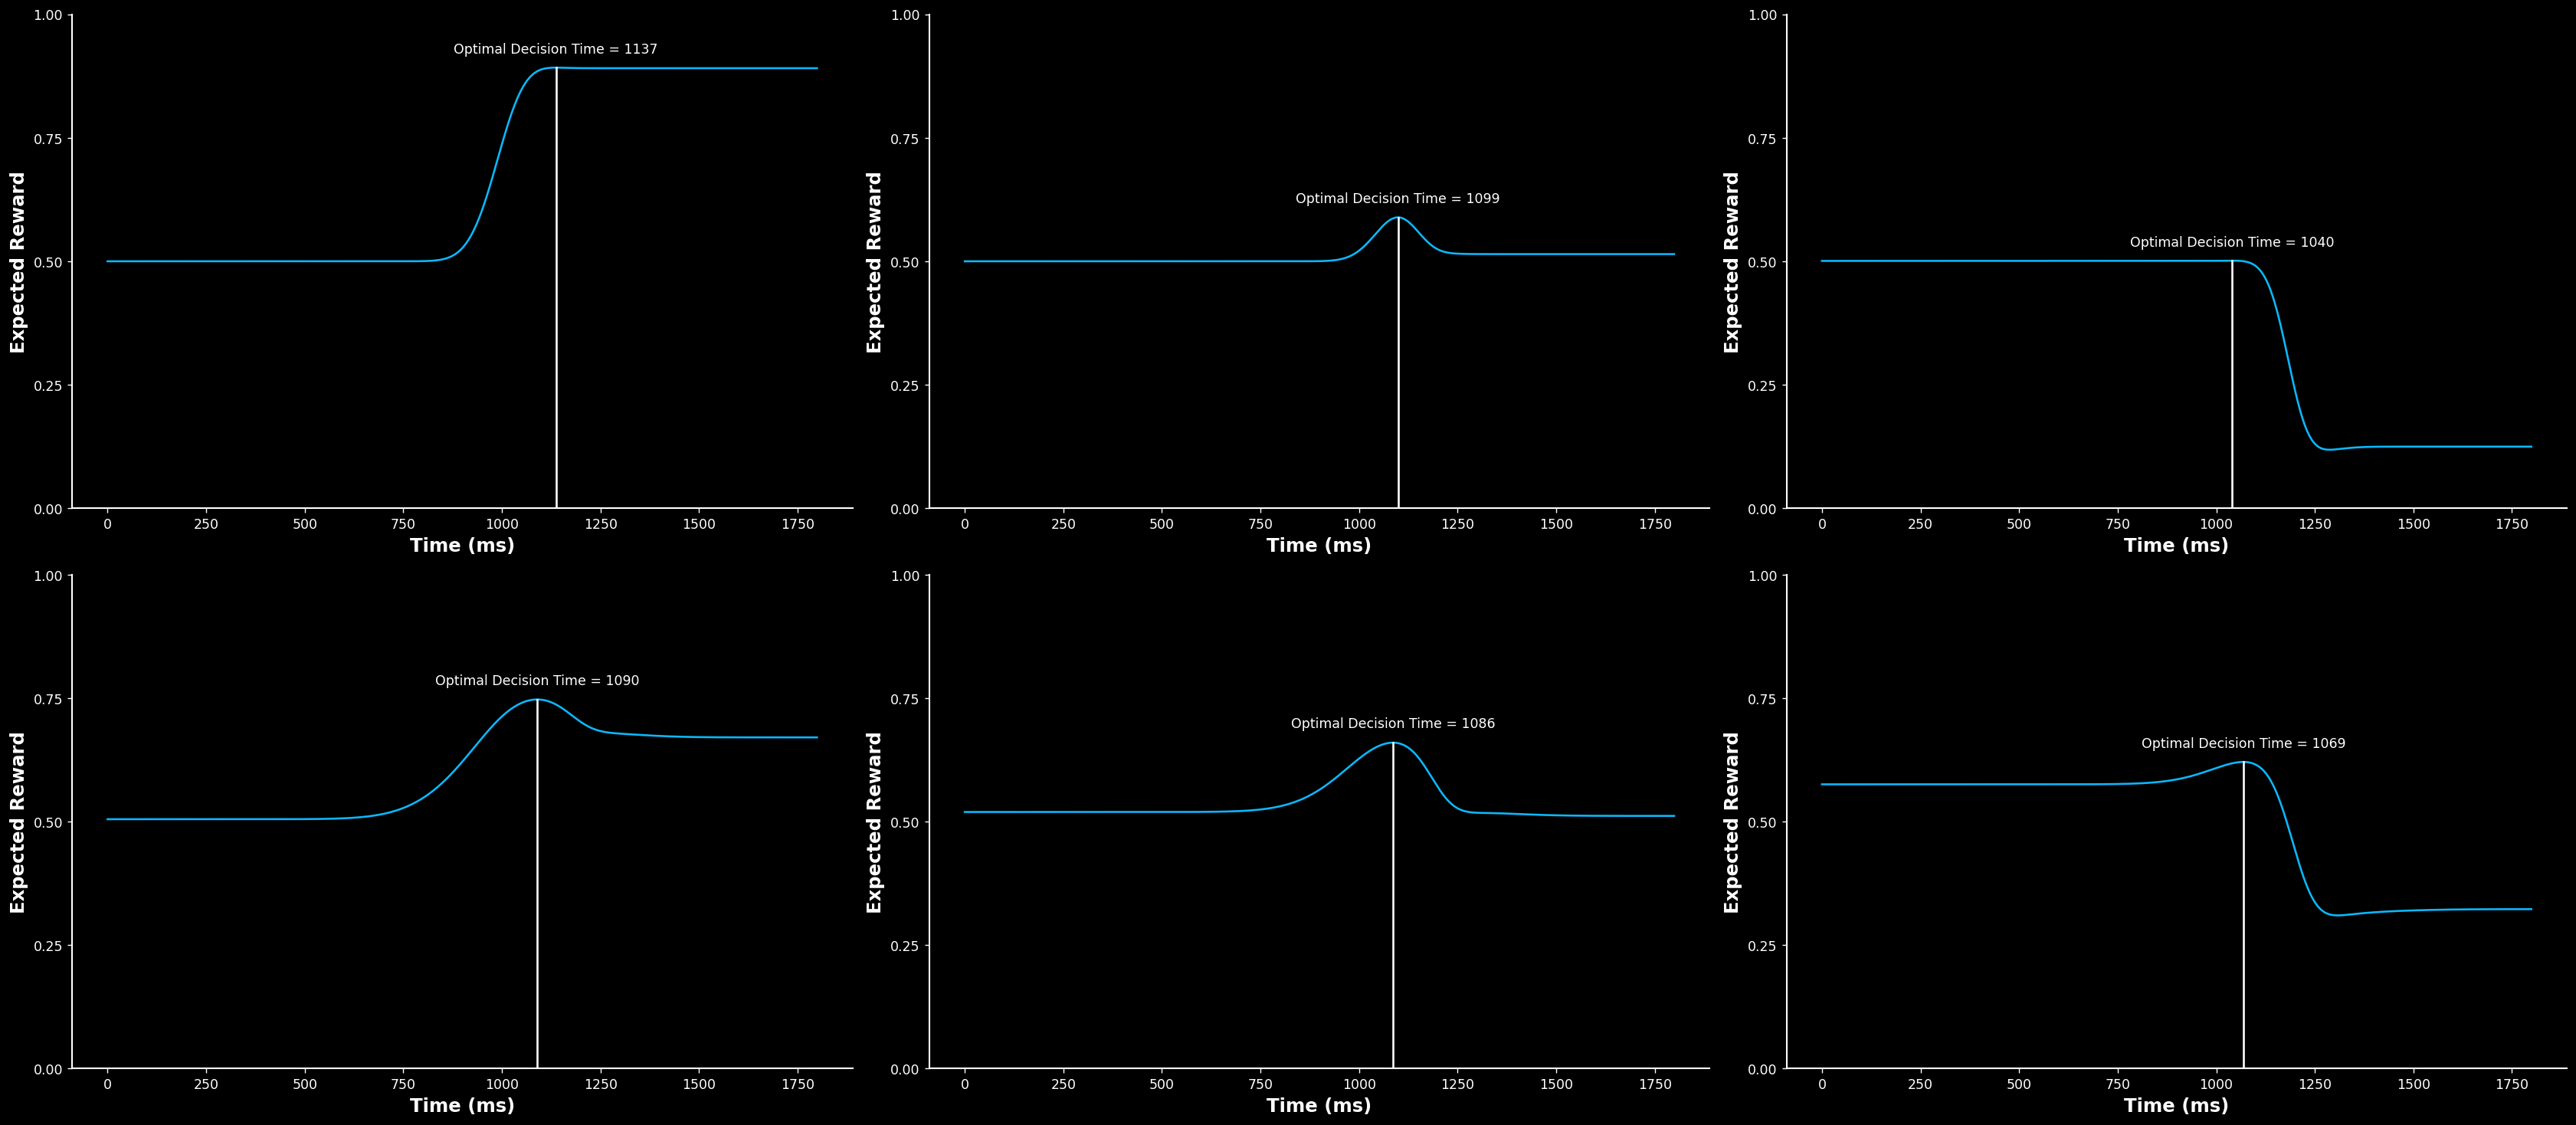

In [32]:
model.plot_optimals(['exp_reward'],titles=[None]*6,ylabel='Expected Reward',dpi=400,figsize=(27,12),)


# Plot Distributions

Reaction Time Uncertainty

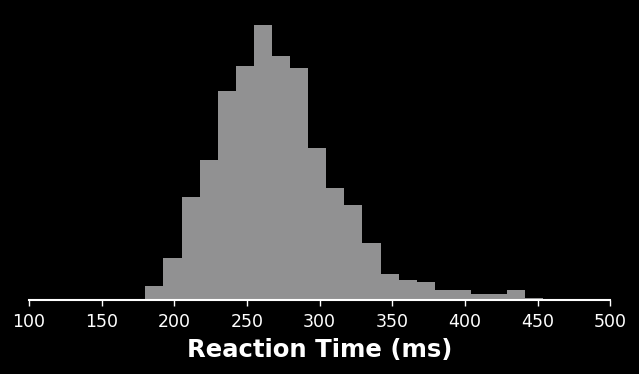

In [33]:
fig,ax = plt.subplots(figsize = (6,3))
group.movement_metrics.get_reaction_times(filter_=False)
ax.hist(group.movement_metrics.reaction_times.flatten(),bins=40,color=wheel.grey)
# ax.axvline(np.nanmedian(group.movement_metrics.reaction_times.flatten()))
ax.set_xlabel('Reaction Time (ms)')
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.set_xlim(100,500)
plt.show()

Movement Time Uncertainty

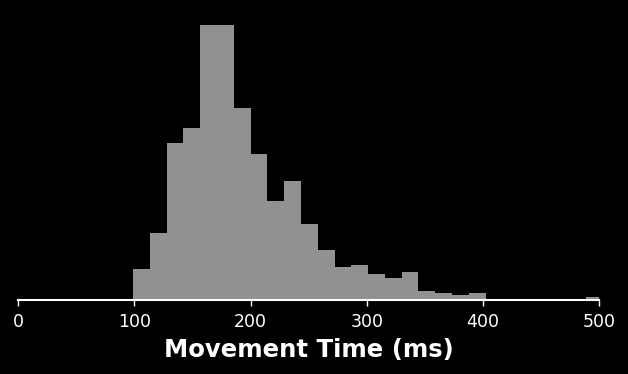

In [34]:
fig,ax = plt.subplots(figsize = (6,3))
ax.hist(group.movement_metrics.movement_times('reaction').flatten(),bins=100,color=wheel.grey)
# ax.axvline(np.nanmedian(group.movement_metrics.reaction_times.flatten()))
ax.set_xlabel('Movement Time (ms)')
ax.set_yticks([])
ax.spines['left'].set_visible(False)
ax.set_xlim(0,500)
plt.show()

Decision Time Uncertainty

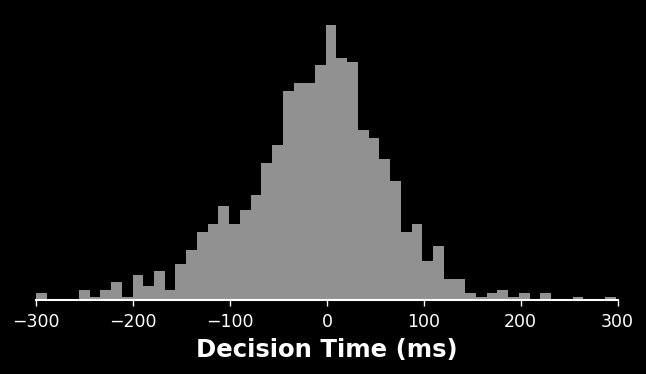

In [35]:
fig,ax = plt.subplots(figsize = (6,3))
ax.hist(group.movement_metrics.coincidence_reach_time.flatten()-1500,bins=100,color=wheel.grey)
ax.set_xlabel('Decision Time (ms)')
# ax.set_ylabel('Counts')
ax.set_xlim(-300,300)
ax.set_yticks([])
ax.spines['left'].set_visible(False)
plt.show()

# Run Stats and Plot

In [36]:
#
#* Set plot constants
SHOW_BOXPLOTS = True
SHOW_MODELS = True
SHOW_STATS = True
w,h = 6,4
mult_w, div_w = 0.9,1.1
div_h = 1.1
bw = (w)/it.num_blocks*2/4 # box widths of all boxes combined takes up 30% of the width
xlocs = np.linspace(0, w/div_w - 0.5, num=len(it.trial_block_titles))
legend_fontsize = 10
#* Get dataframe and create the stats inputs
df = st.generate_dataframe(group, EXPERIMENT, DROP_SUBJECT_NUM=None)
# display(df)

stats_inputs = st.Inputs(
    df, experiment = EXPERIMENT, num_subjects = len(df['Subject'].unique()), 
    num_blocks=it.num_blocks,num_trials=it.num_trials,
    trial_block_titles=it.trial_block_titles,xlab=it.xlabel,
    f1_xticklabels=it.f1_collapse_xticklabs,f2_xticklabels=it.f2_collapse_xticklabs,
    f1_xlabel=it.f1_xlabel,f2_xlabel=it.f2_xlabel,
    M = 1e6
)

!! DROPPING SUBJECT None !! 


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


## Median Movement Onset 

### Stats

In [37]:
median_movement_onset_anova = st.Anova('Median_Movement_Onset_Time', stats_inputs)
display(median_movement_onset_anova.anova)
median_movement_onset_boot = st.Bootstrap(stats_inputs, median_movement_onset_anova,
                                          no_collapse=True, alternative='variable', test='median')
median_movement_onset_statistics = median_movement_onset_boot.run_bootstrap()
median_movement_onset_statistics

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,59699.487500,2,38,29849.743750,4.360600,0.019730,0.030075,0.031095,0.775649
1,Factor_2,66811.602083,1,19,66811.602083,6.815716,0.017188,0.017188,0.034671,1.000000
2,Factor_1 * Factor_2,2723.429167,2,38,1361.714583,0.521157,0.598016,0.565215,0.001462,0.828255


Significant interaction, doing pairwise bootstraps for each condition...


[{'02': 0.0,
  '04': 0.436572,
  '13': 0.501576,
  '15': 0.501576,
  '24': 0.02248,
  '35': 0.43778700000000004},
 {'02': 70.0, '04': 65.0, '13': 75.0, '15': 50.0, '24': 60.0, '35': 65.0}]

### Plot

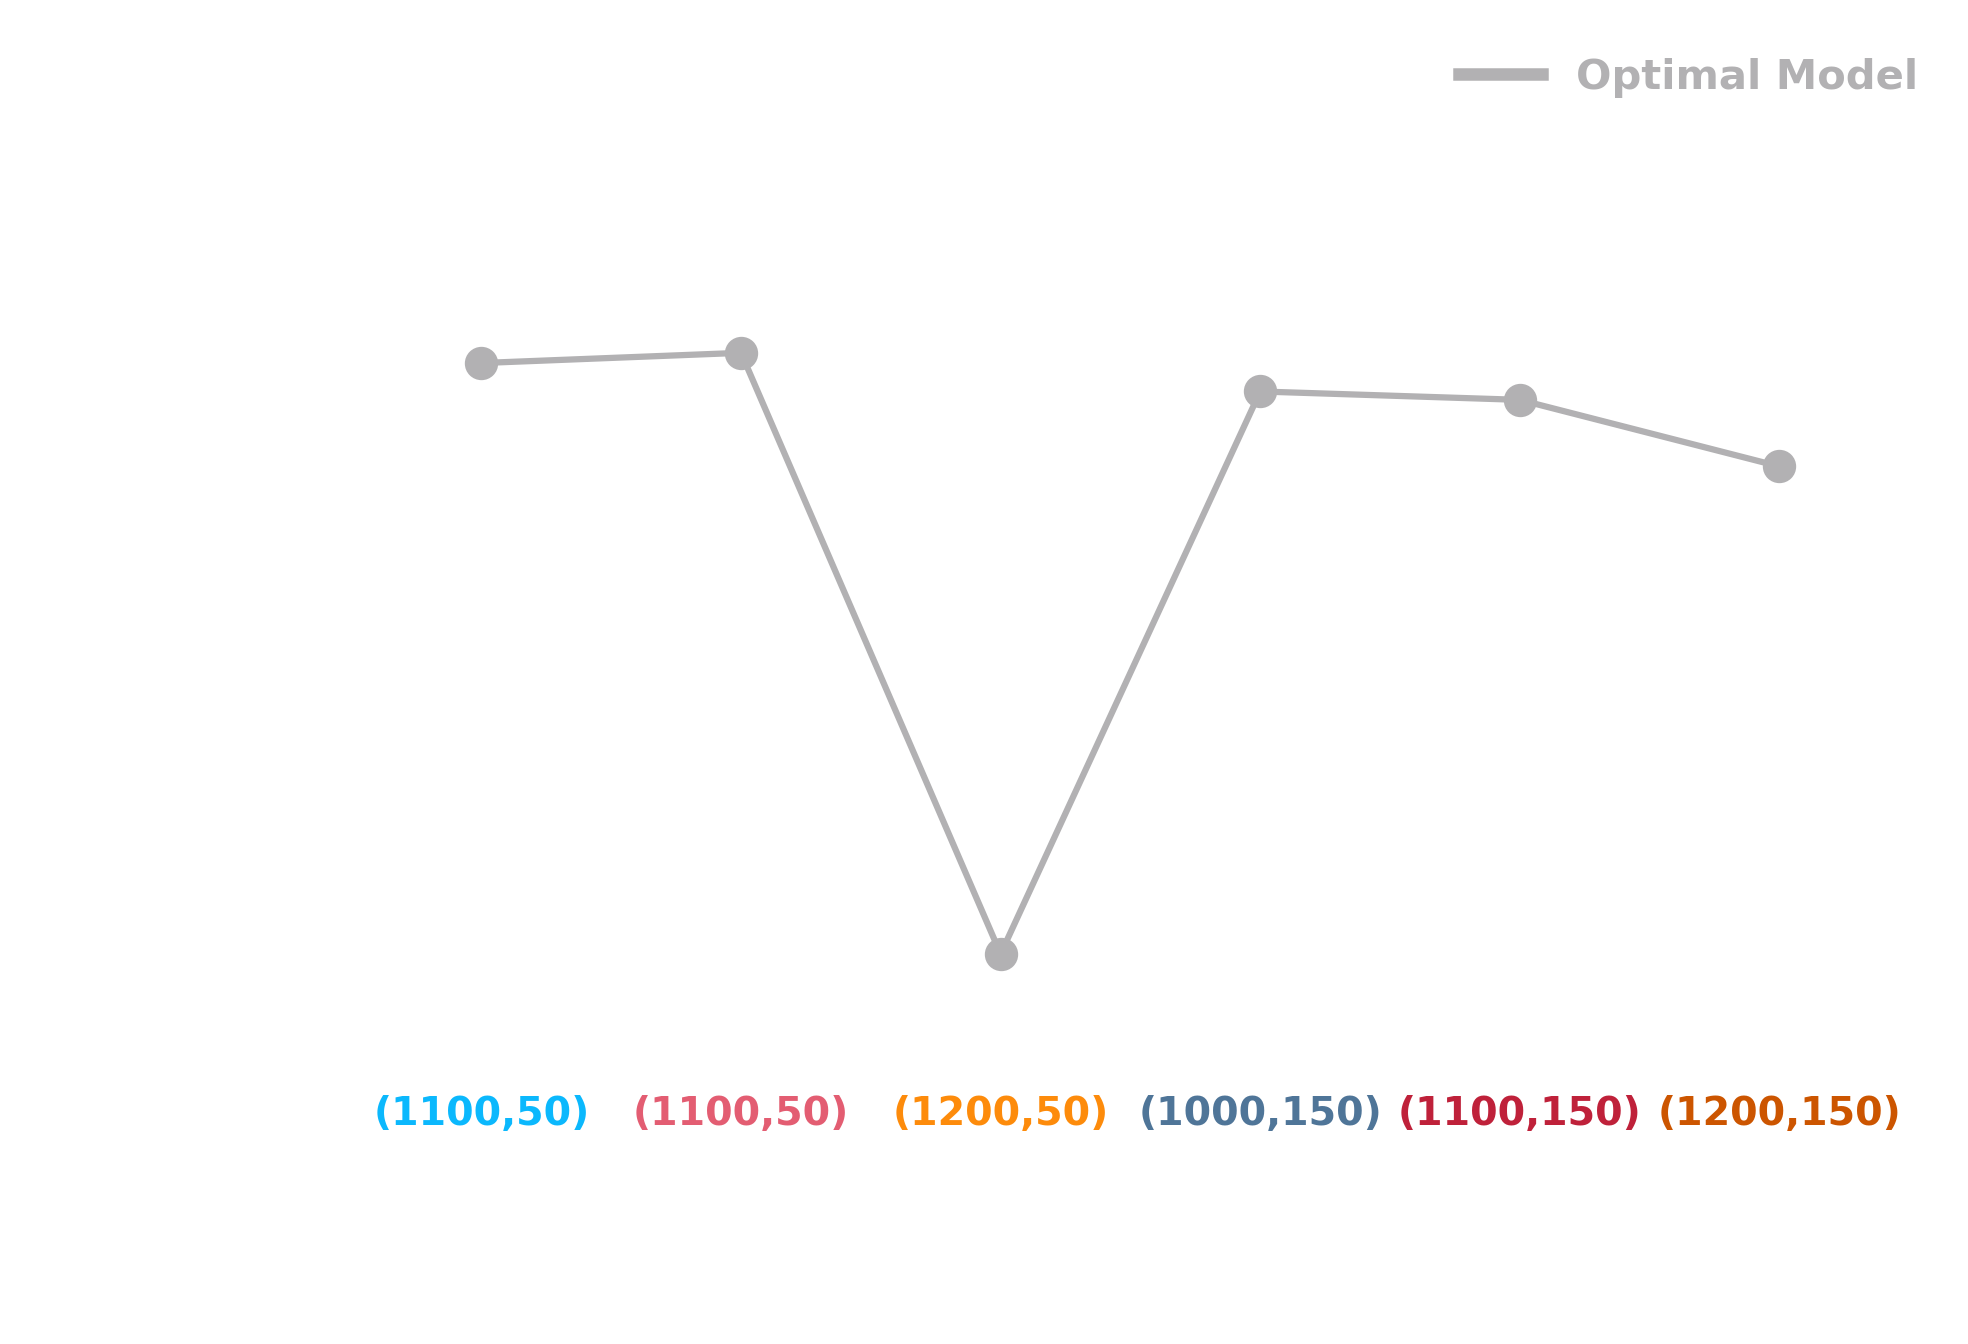

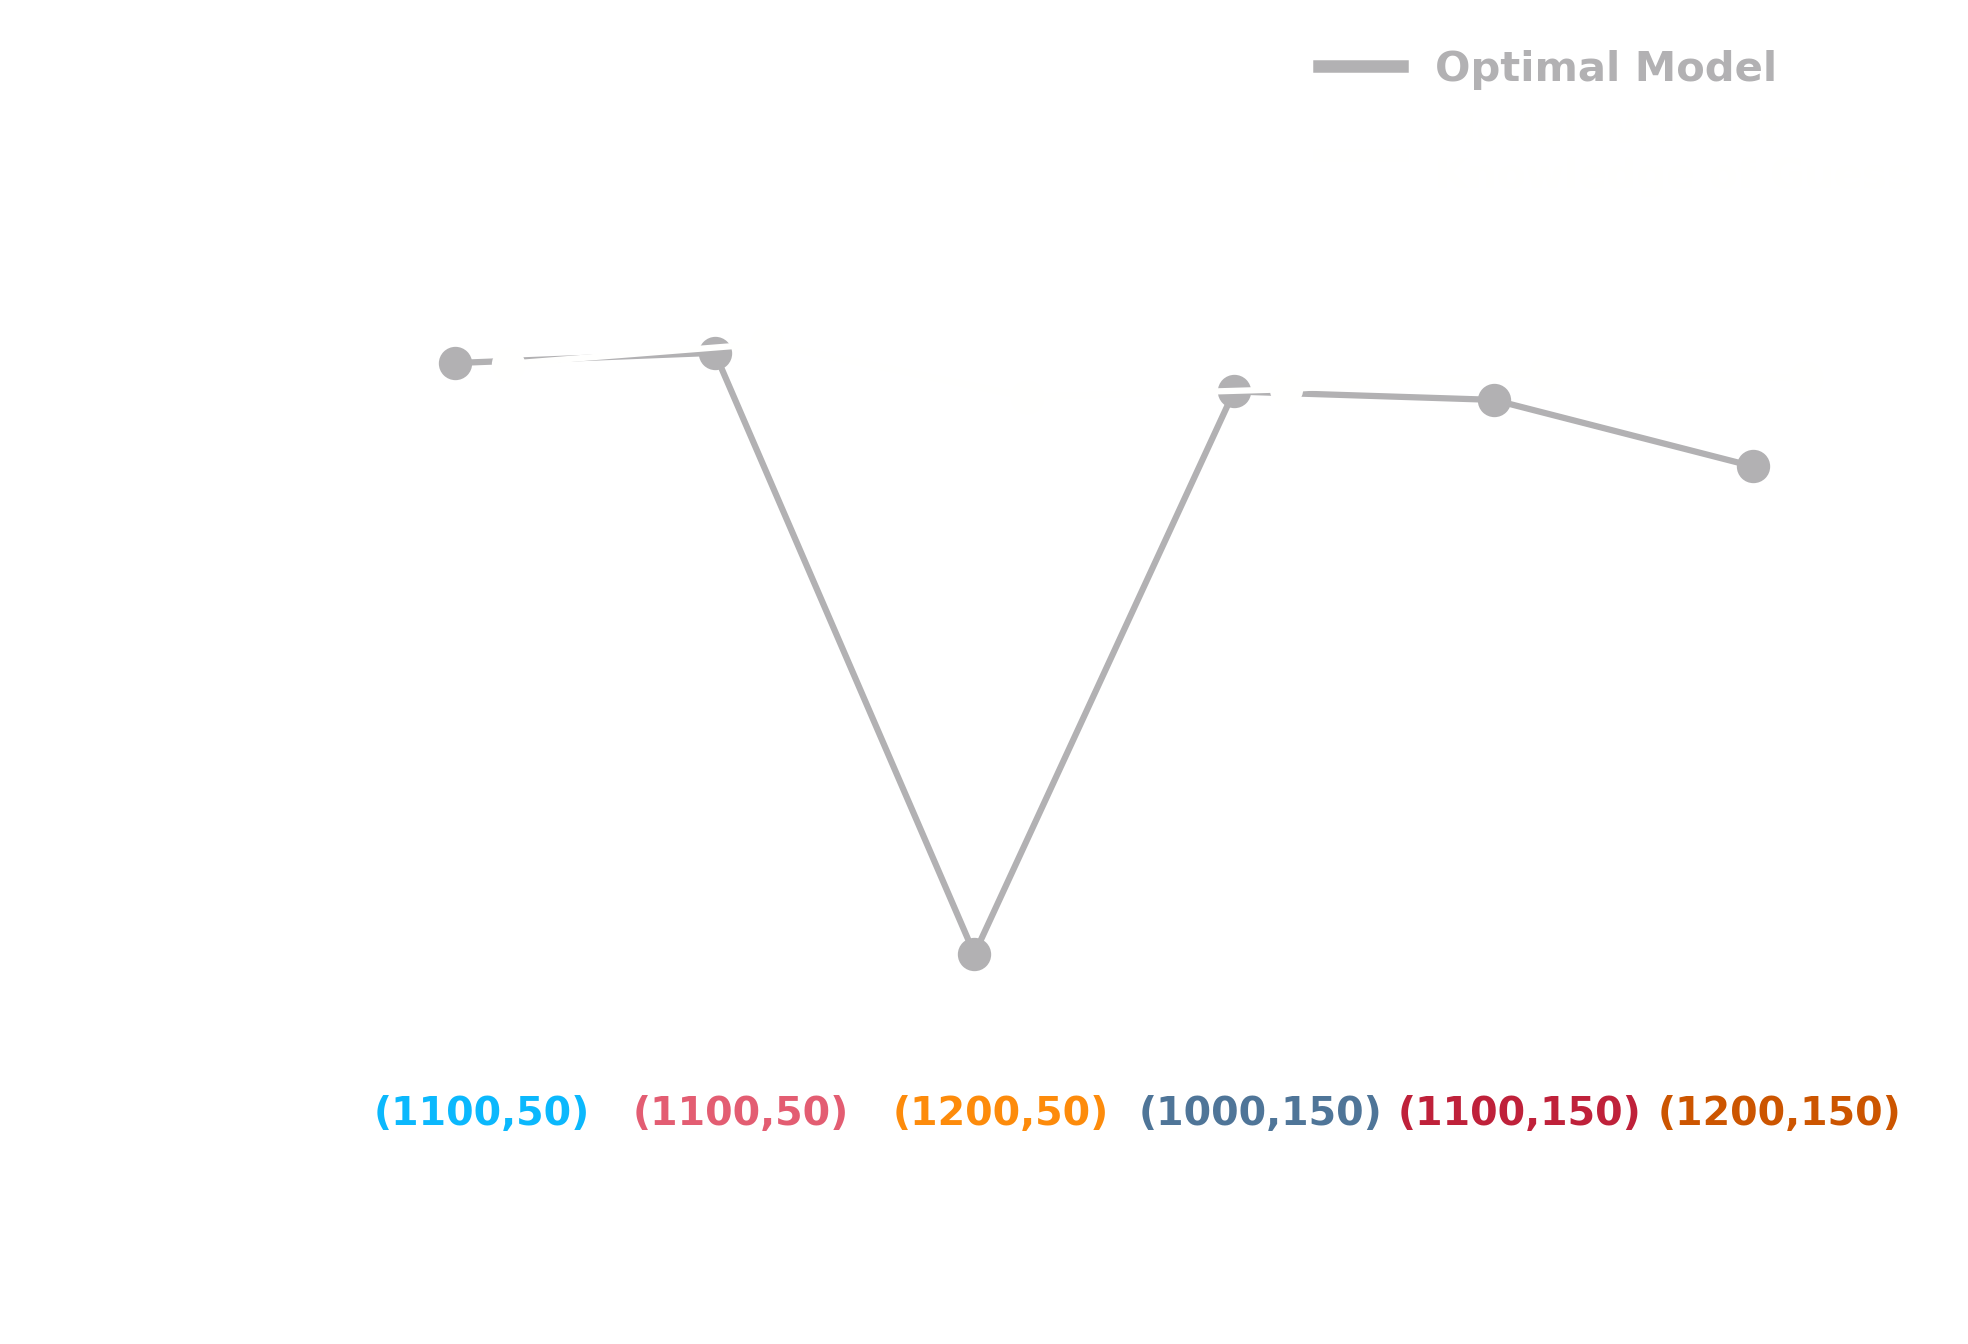

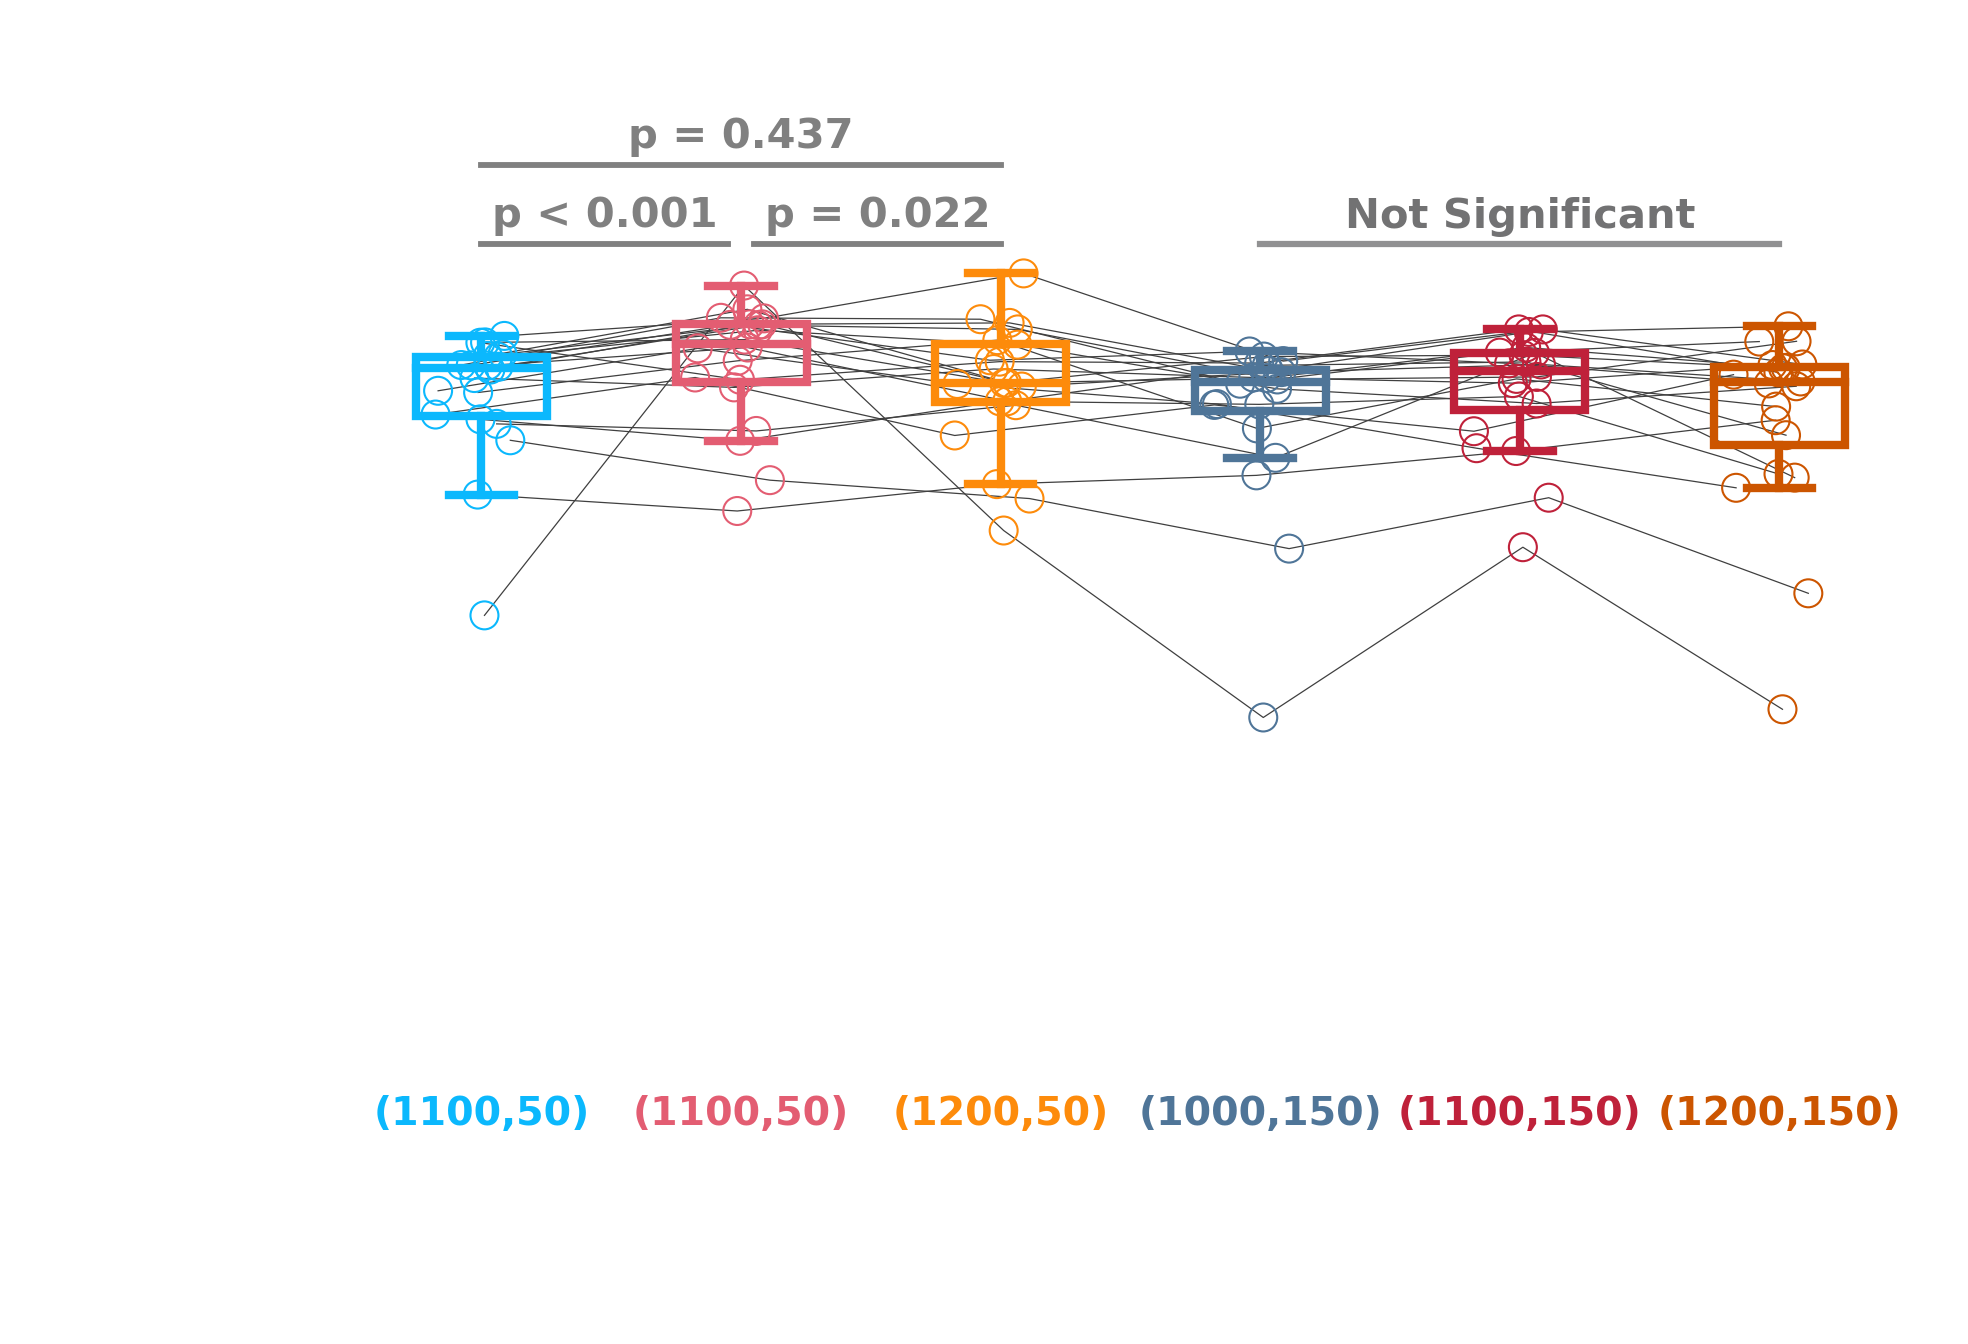

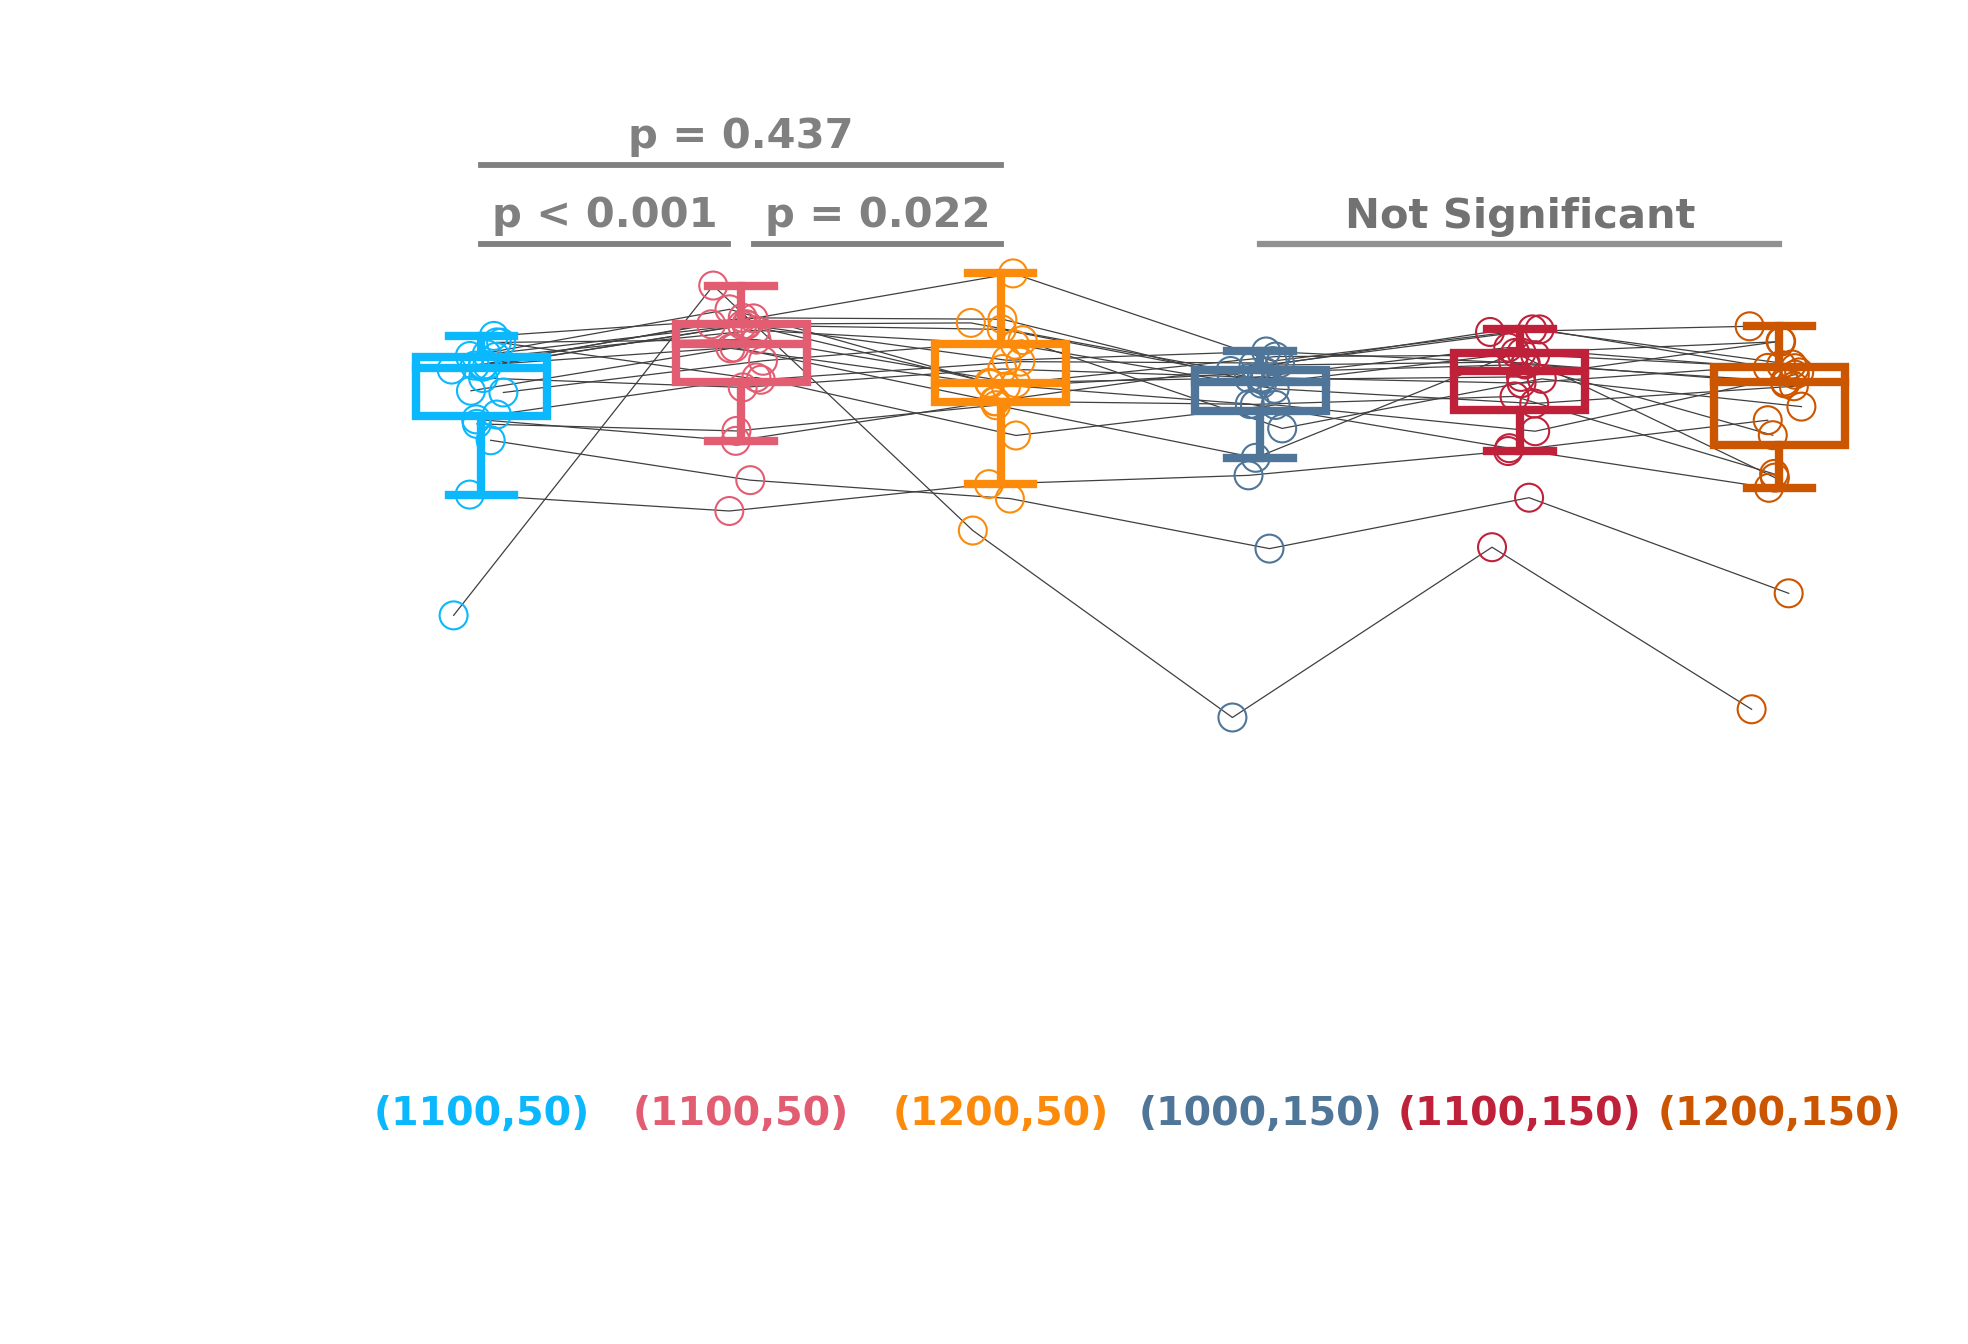

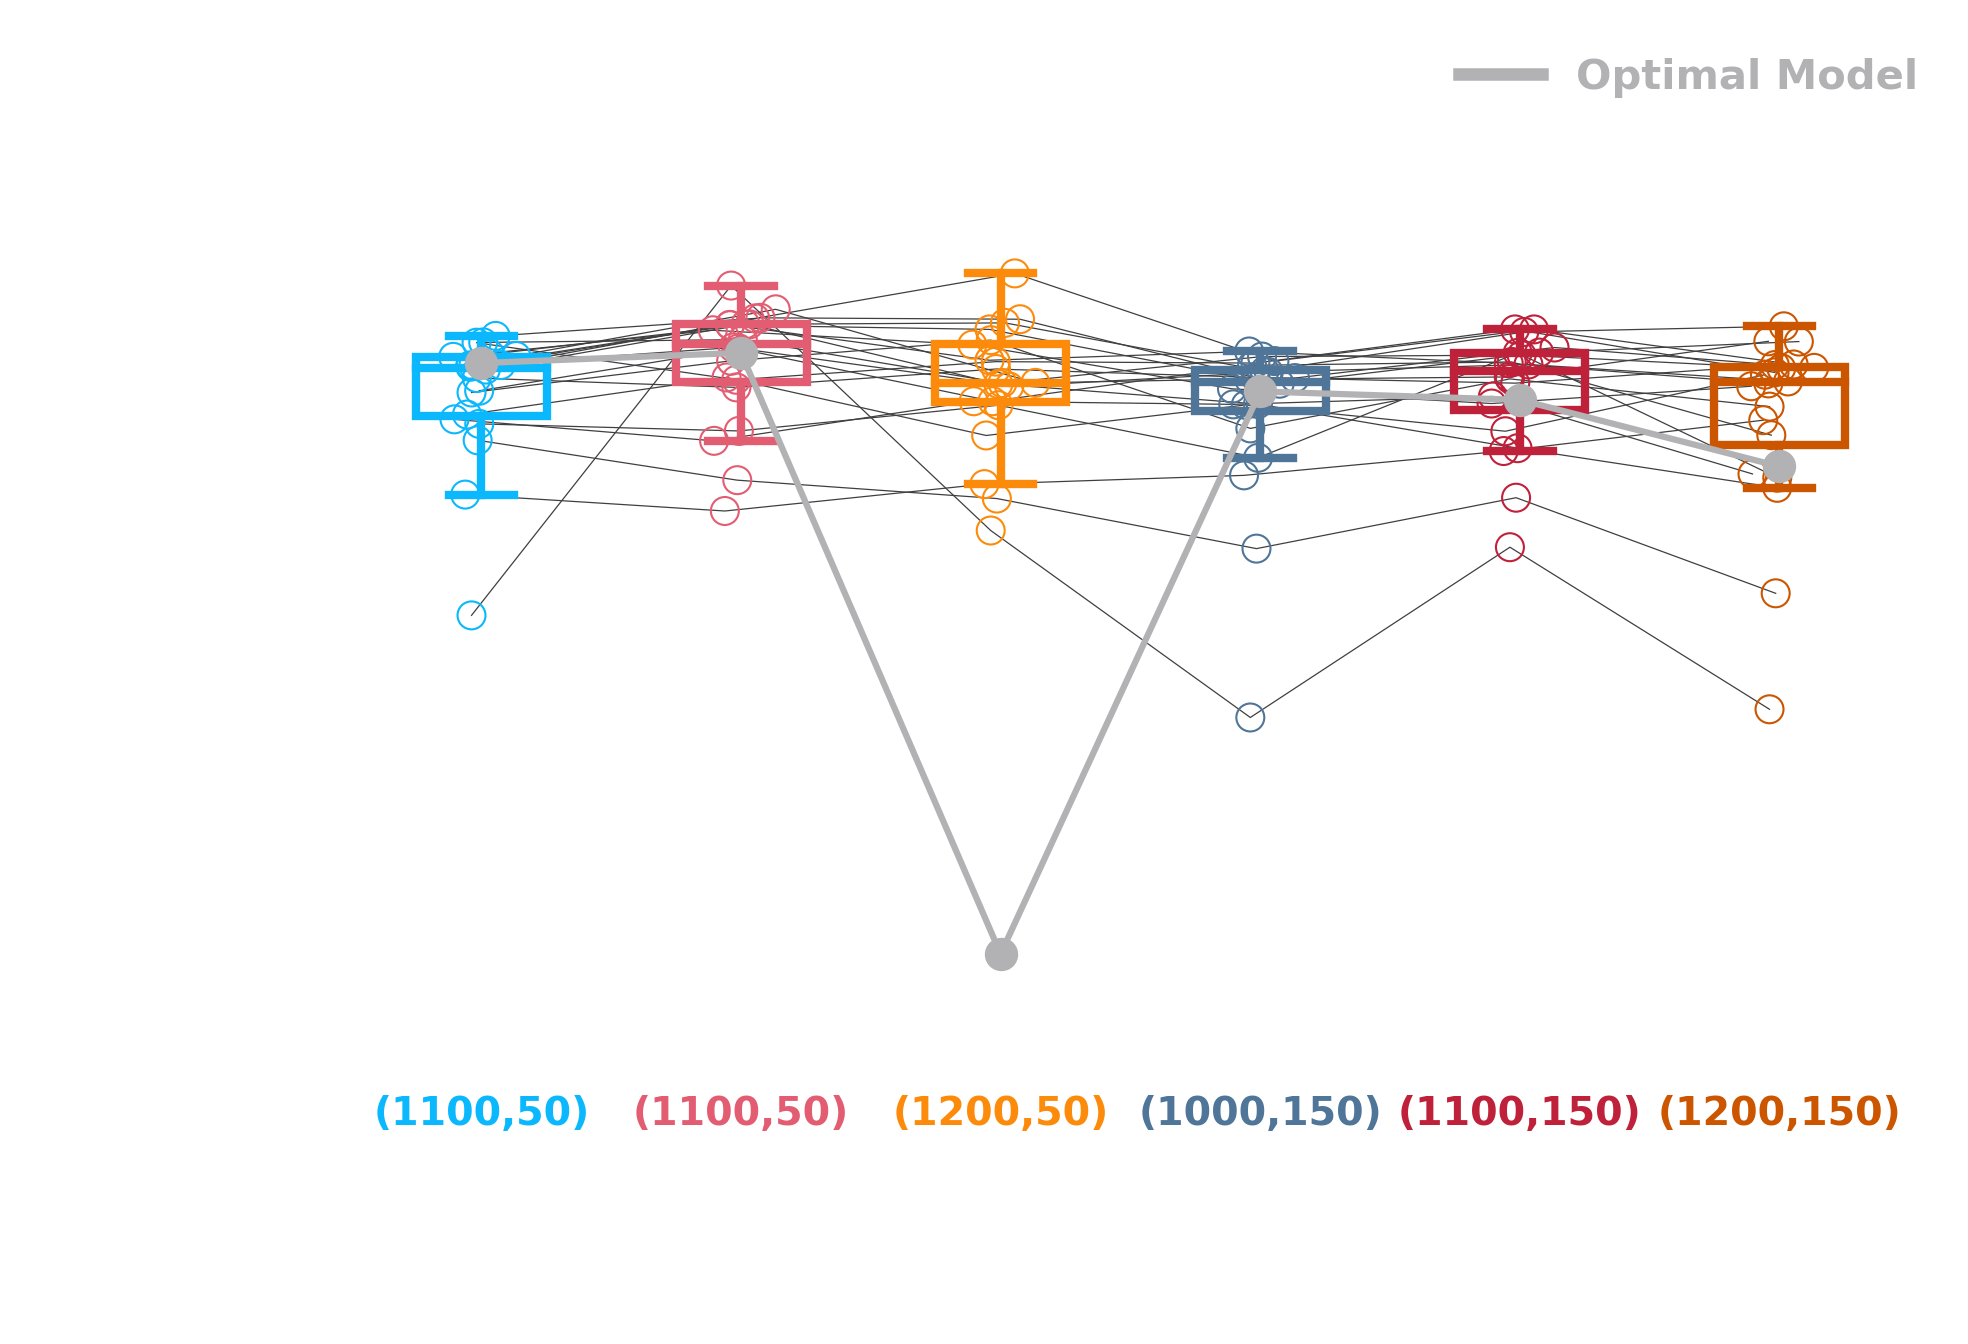

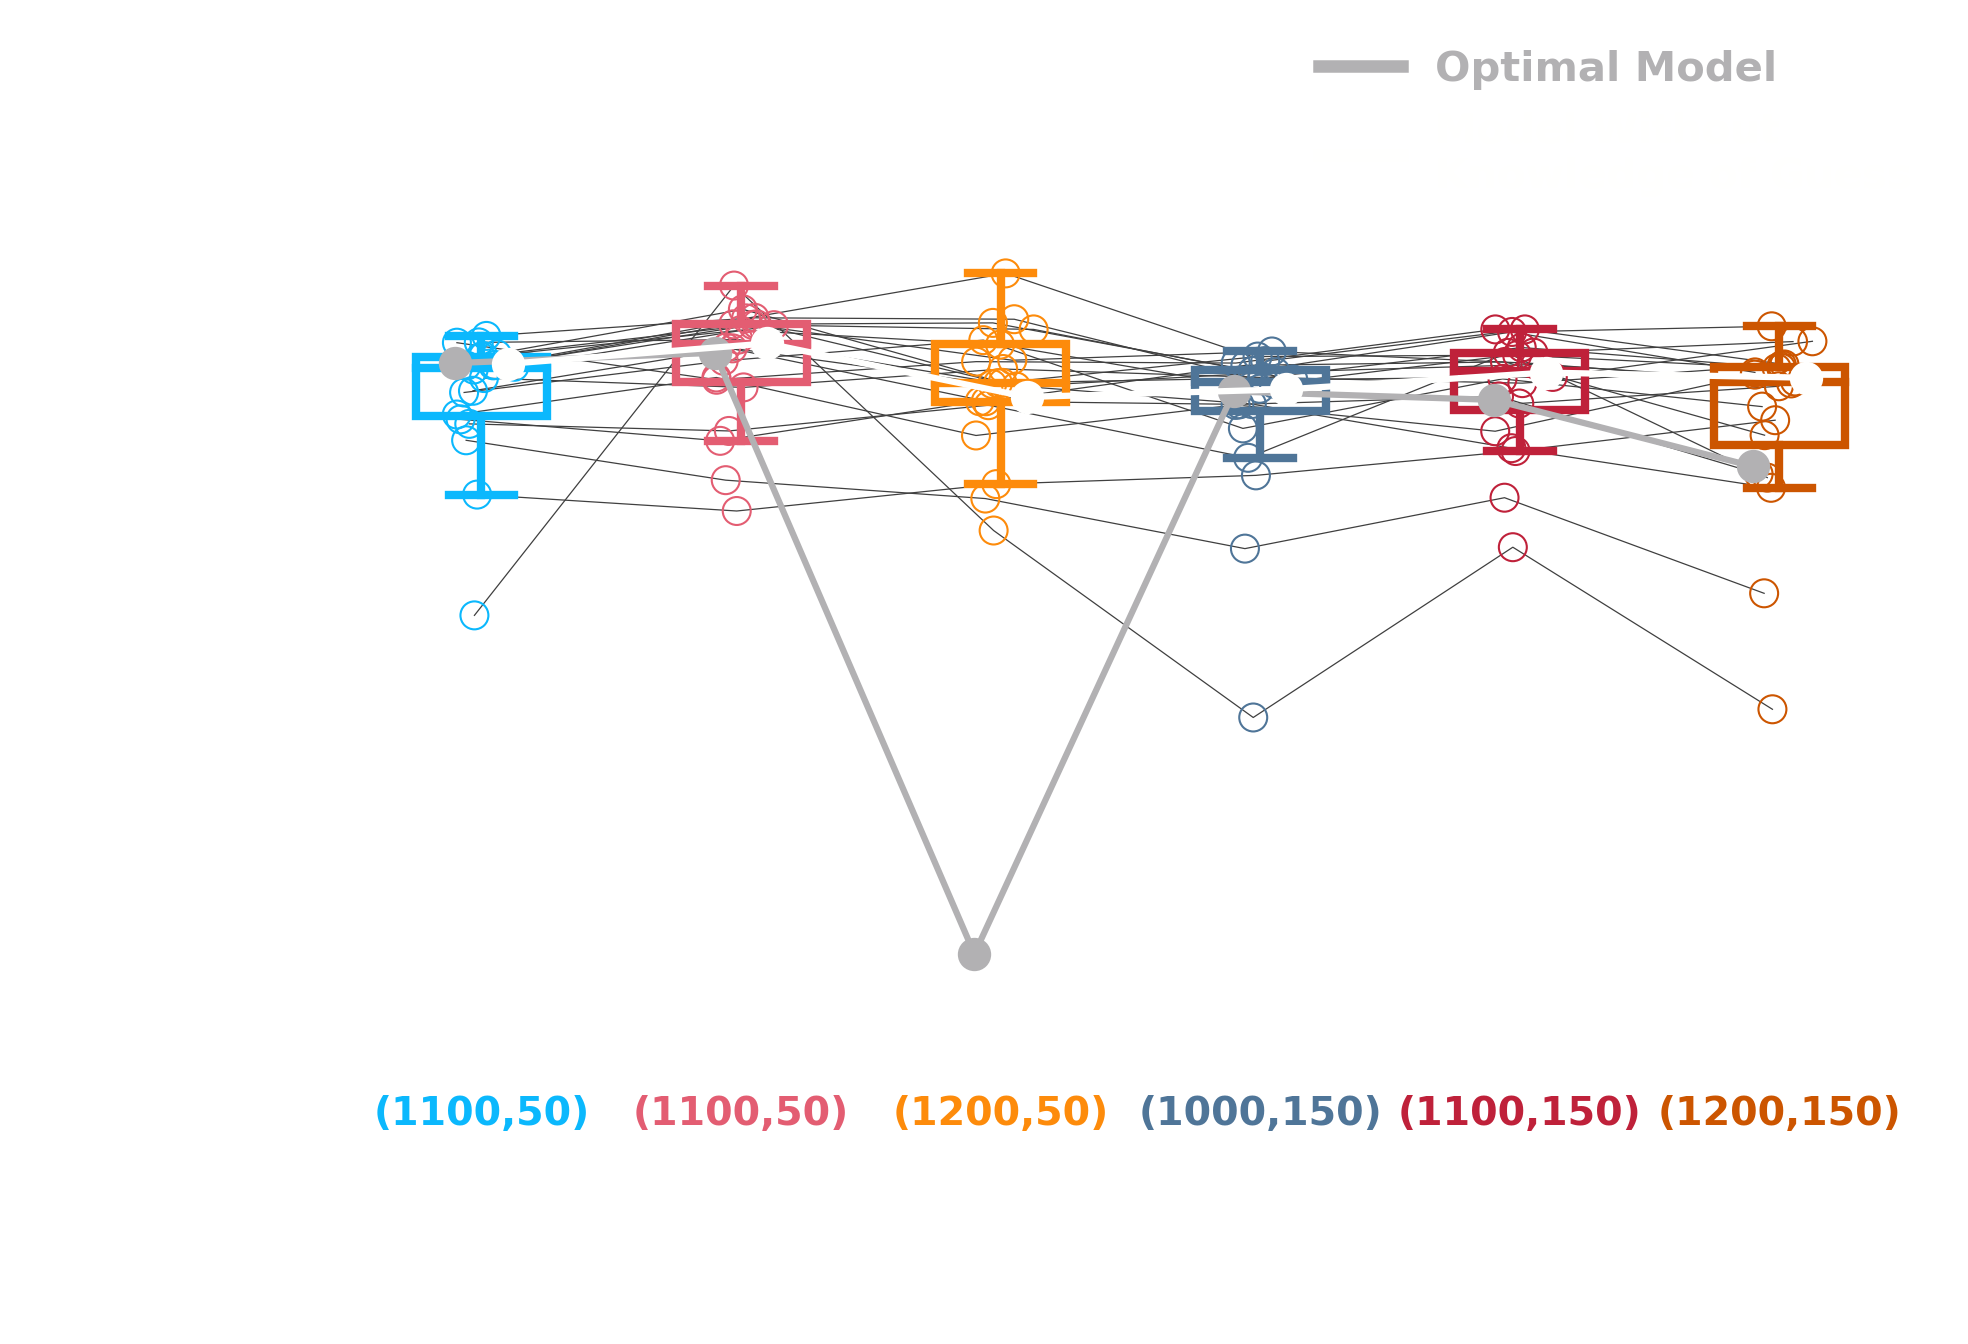

0.5


In [140]:

# Loop 1 - models
model_list = [
    [model.results.get_metric(model.player_behavior.wtd_leave_time,
    metric_type='true',decision_type='optimal') for key,model in models.items() if key == 'Theoretical Optimal'],
    [model.results.get_metric(model.player_behavior.wtd_leave_time,
    metric_type='true',decision_type='optimal') for model in models.values()],
]
model_labels = [['Optimal Model'], ['Optimal Model', 'Model Without\nKnowledge of Guess']]
legend_locs  = [(0.7,0.96), (0.61,0.86)]
# Loop 2
save_names = [
    ['only_model_optimal','only_model_both',],
    ['stats','stats'],
    ['data_and_model_optimal','data_and_model_both']
]
show_boxplots = [False, True, True]
show_models   = [True, False, True]
show_stats    = [False, True, False]
for i in range(len(save_names)):
    for j,model_data in enumerate(model_list):
        metric = st.df_to_array(df['Median_Movement_Onset_Time'],stats_inputs.num_subjects, stats_inputs.num_blocks)
        ylocs = np.arange(0, 1751, 250)
        ylabel = 'Movement Onset Time (ms)'

        fig = dv.Figure(figsize=(w, h), dpi=300)
        ax = fig.add_panel(dim=(0.75, 0.1, 5.2, 3.3))
        pf.multiple_models_boxplot(
                ax=ax,
                data=metric,
                box_width = bw,
                model_data=model_data,
                show_boxplot=show_boxplots[i],
                show_models=show_models[i],
                reorder_xaxis = True,
                labels=model_labels[j],
                box_colors=[wheel.rak_blue, wheel.rak_red, wheel.rak_orange,wheel.dark_blue_hc,wheel.lighten_color(wheel.rak_red,1.5), wheel.burnt_orange,],
                line_colors = [wheel.lighten_color(wheel.light_grey,1), wheel.lighten_color(wheel.light_grey,0)],
                jitter_data = False,
                jitter = True,
                data_markersize=45,
                linestyles=None,
                xlocs=xlocs,
                # xtick_locs = np.linspace(1, w/div_w - 0.5, num=len(it.trial_block_titles)),
                ylocs=ylocs,
                xticklabels=it.trial_block_titles,
                xlabel=it.xlabel,
                ylabel=ylabel,
                legend_fontsize=legend_fontsize,
                legend_loc=legend_locs[j],
                model_markersize=7,
            )
        ax.set_ylim(0,1750)
        ax.set_xlim(-0.5,max(xlocs)+0.5)
        ax.xaxis.set_tick_params(labelsize=9.5)
        ax.yaxis.set_tick_params(labelsize=9.5)        
        # ax.spines.bottom.set_visible(False)
        # ax.tick_params(axis='x',bottom=False)
        ax.set_facecolor('none')

        if show_stats[i]:
            pf.plot_stats(
                ax,stats_inputs=stats_inputs, statistics=median_movement_onset_statistics,
                combos = ['02','24','04',],
                xpositions = [[xlocs[0],xlocs[1]-0.05], 
                            [xlocs[1]+0.05, xlocs[2]],
                            [xlocs[0],xlocs[2]]],
                ypos=[1451,1451,1590,1420,1490],
                stacked=True,
                show_effectsize=False,
                lw = 1.4, 
                h = 16,
                fontsize=10,
                shorten_length=True
            )
            ax.plot((xlocs[3],xlocs[-1]),(1451,1451),color=wheel.grey)
            ax.text((xlocs[3]+xlocs[-1])/2, 1500, 'Not Significant', color=wheel.dark_grey, ha = 'center', va='center',fontweight='bold')
        plt.show()
        fig.savefig(SAVE_PATH / f'movement_onset_times_{save_names[i][j]}')
        # Don't need to run two models if we're doing stats
        if save_names[i] == 'stats':
            break

## Indecisions

In [114]:
indecisions_anova = st.Anova('Indecisions', stats_inputs)
display(indecisions_anova.anova)
indecisions_boot = st.Bootstrap(stats_inputs, indecisions_anova,no_collapse=True,alternative='two-sided')
indecisions_statistics = indecisions_boot.run_bootstrap()
indecisions_statistics

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,2481.432292,2,38,1240.716146,10.003995,0.000323,0.000528,0.111388,0.910429
1,Factor_2,132.825521,1,19,132.825521,1.017642,0.325754,0.325754,0.006665,1.000000
2,Factor_1 * Factor_2,1216.432292,2,38,608.216146,5.577994,0.007515,0.013381,0.057891,0.785547


Significant interaction, doing pairwise bootstraps for each condition...


[{'02': 0.000234,
  '04': 0.00393,
  '13': 0.135052,
  '15': 1.0,
  '24': 1.0,
  '35': 0.593361},
 {'02': 85.0,
  '04': 80.0,
  '13': 62.5,
  '15': 57.49999999999999,
  '24': 60.0,
  '35': 65.0}]

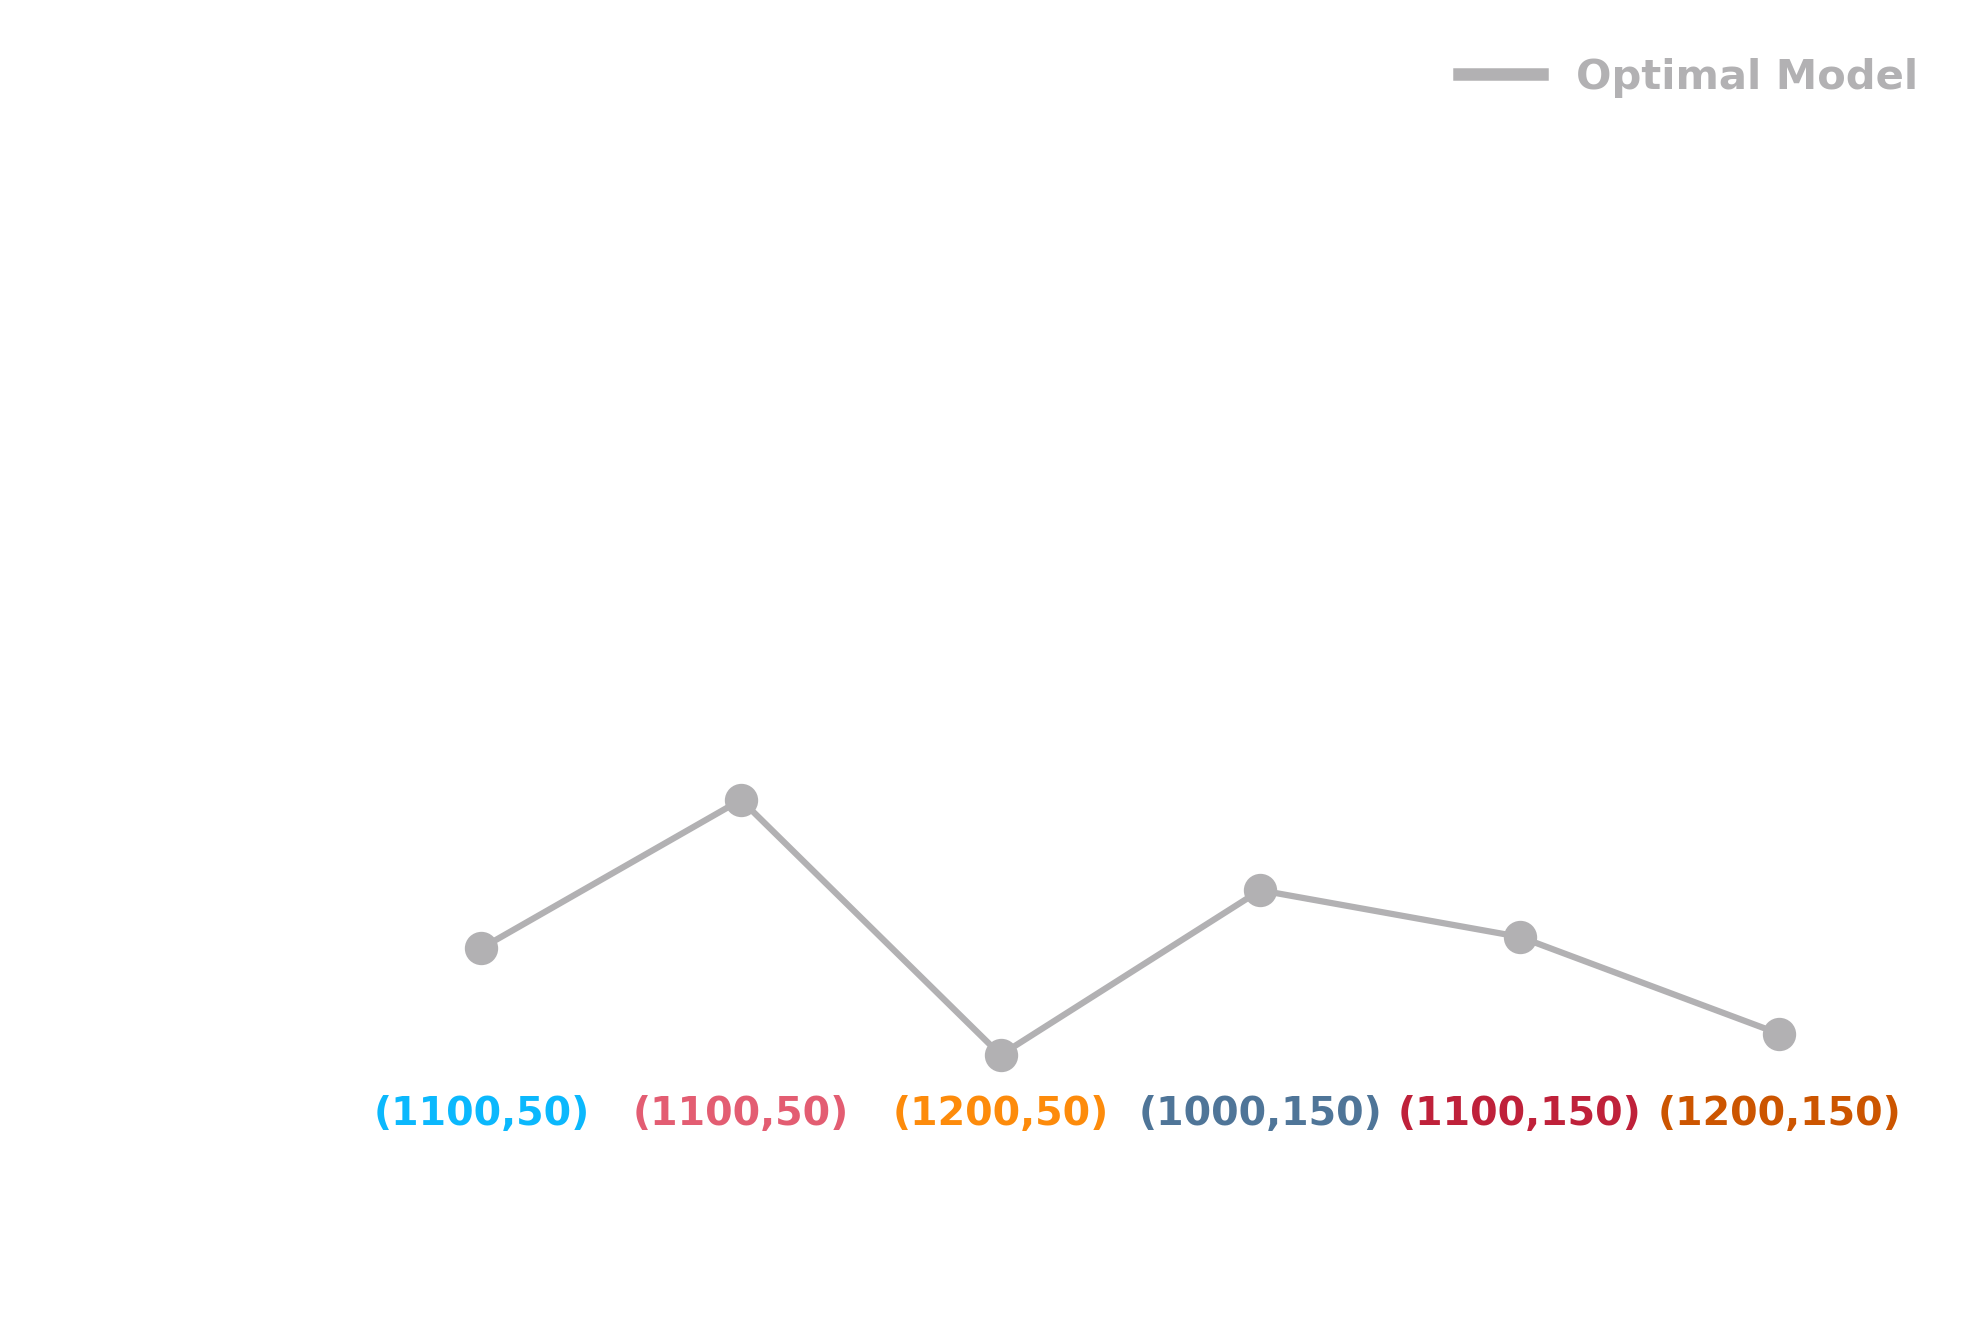

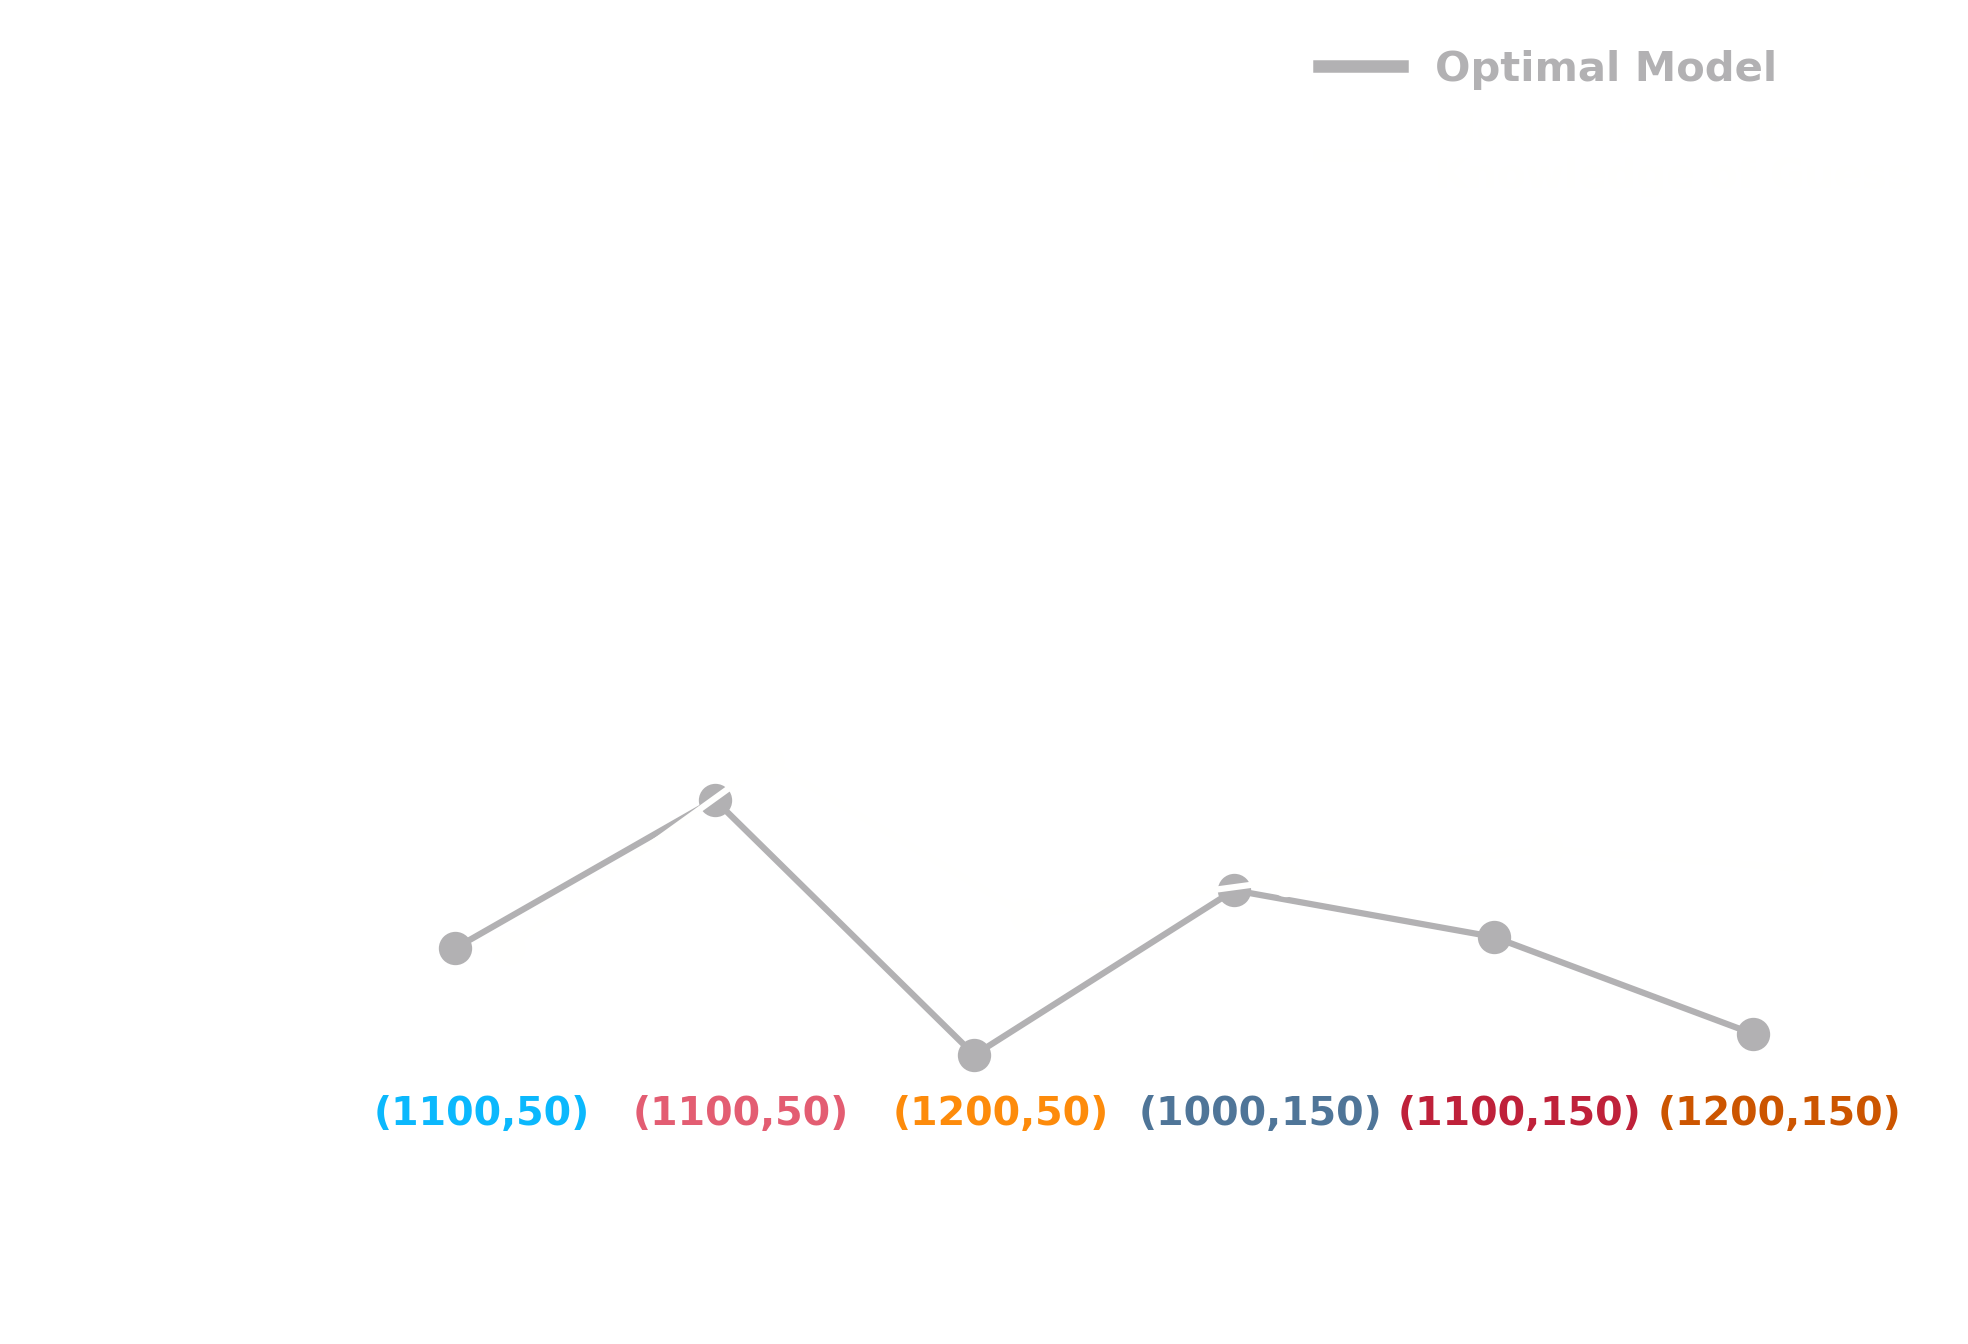

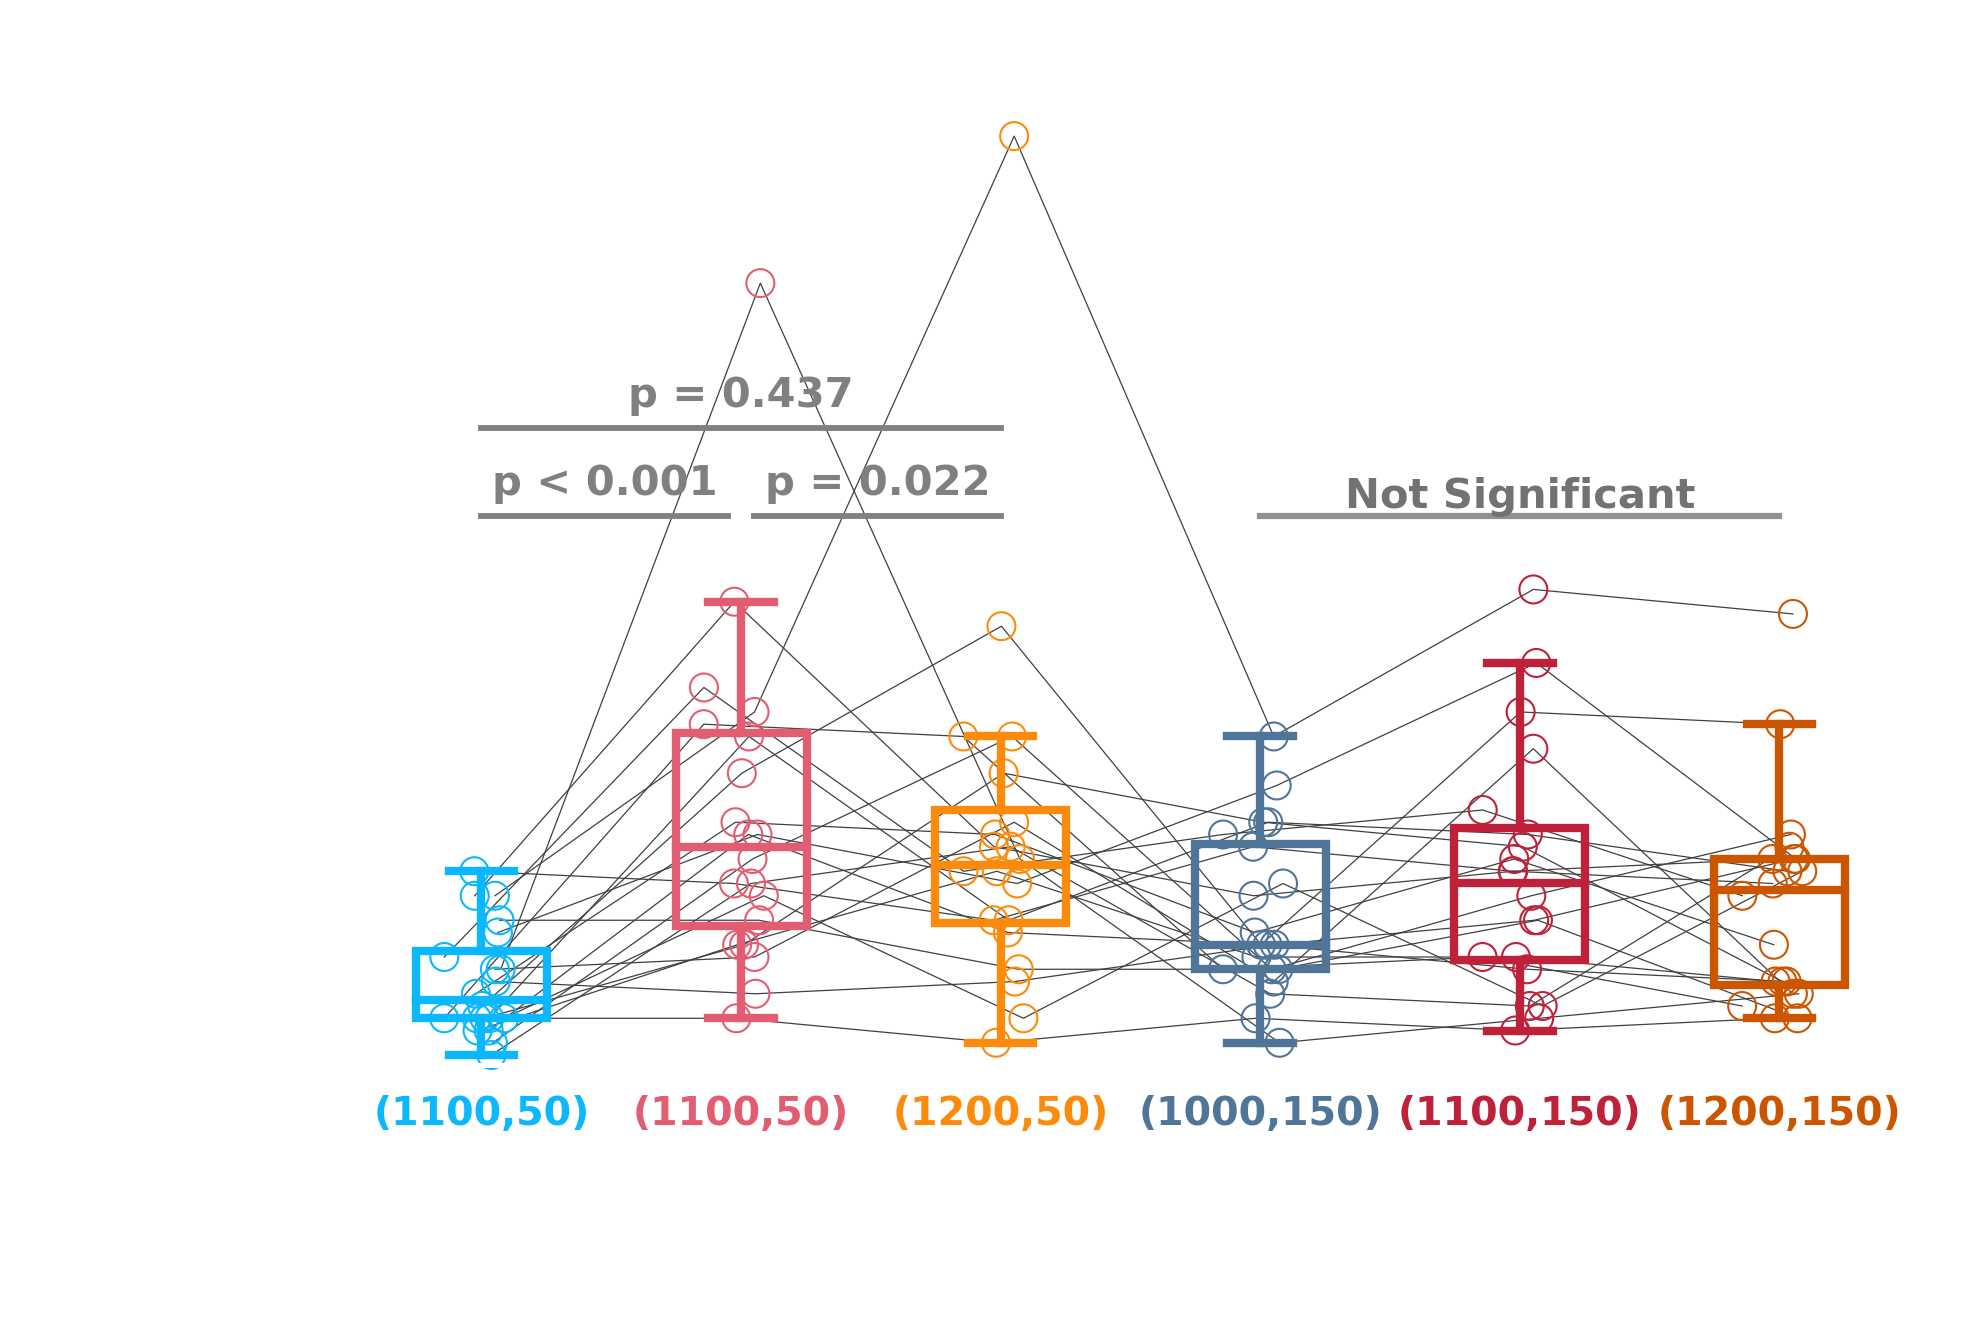

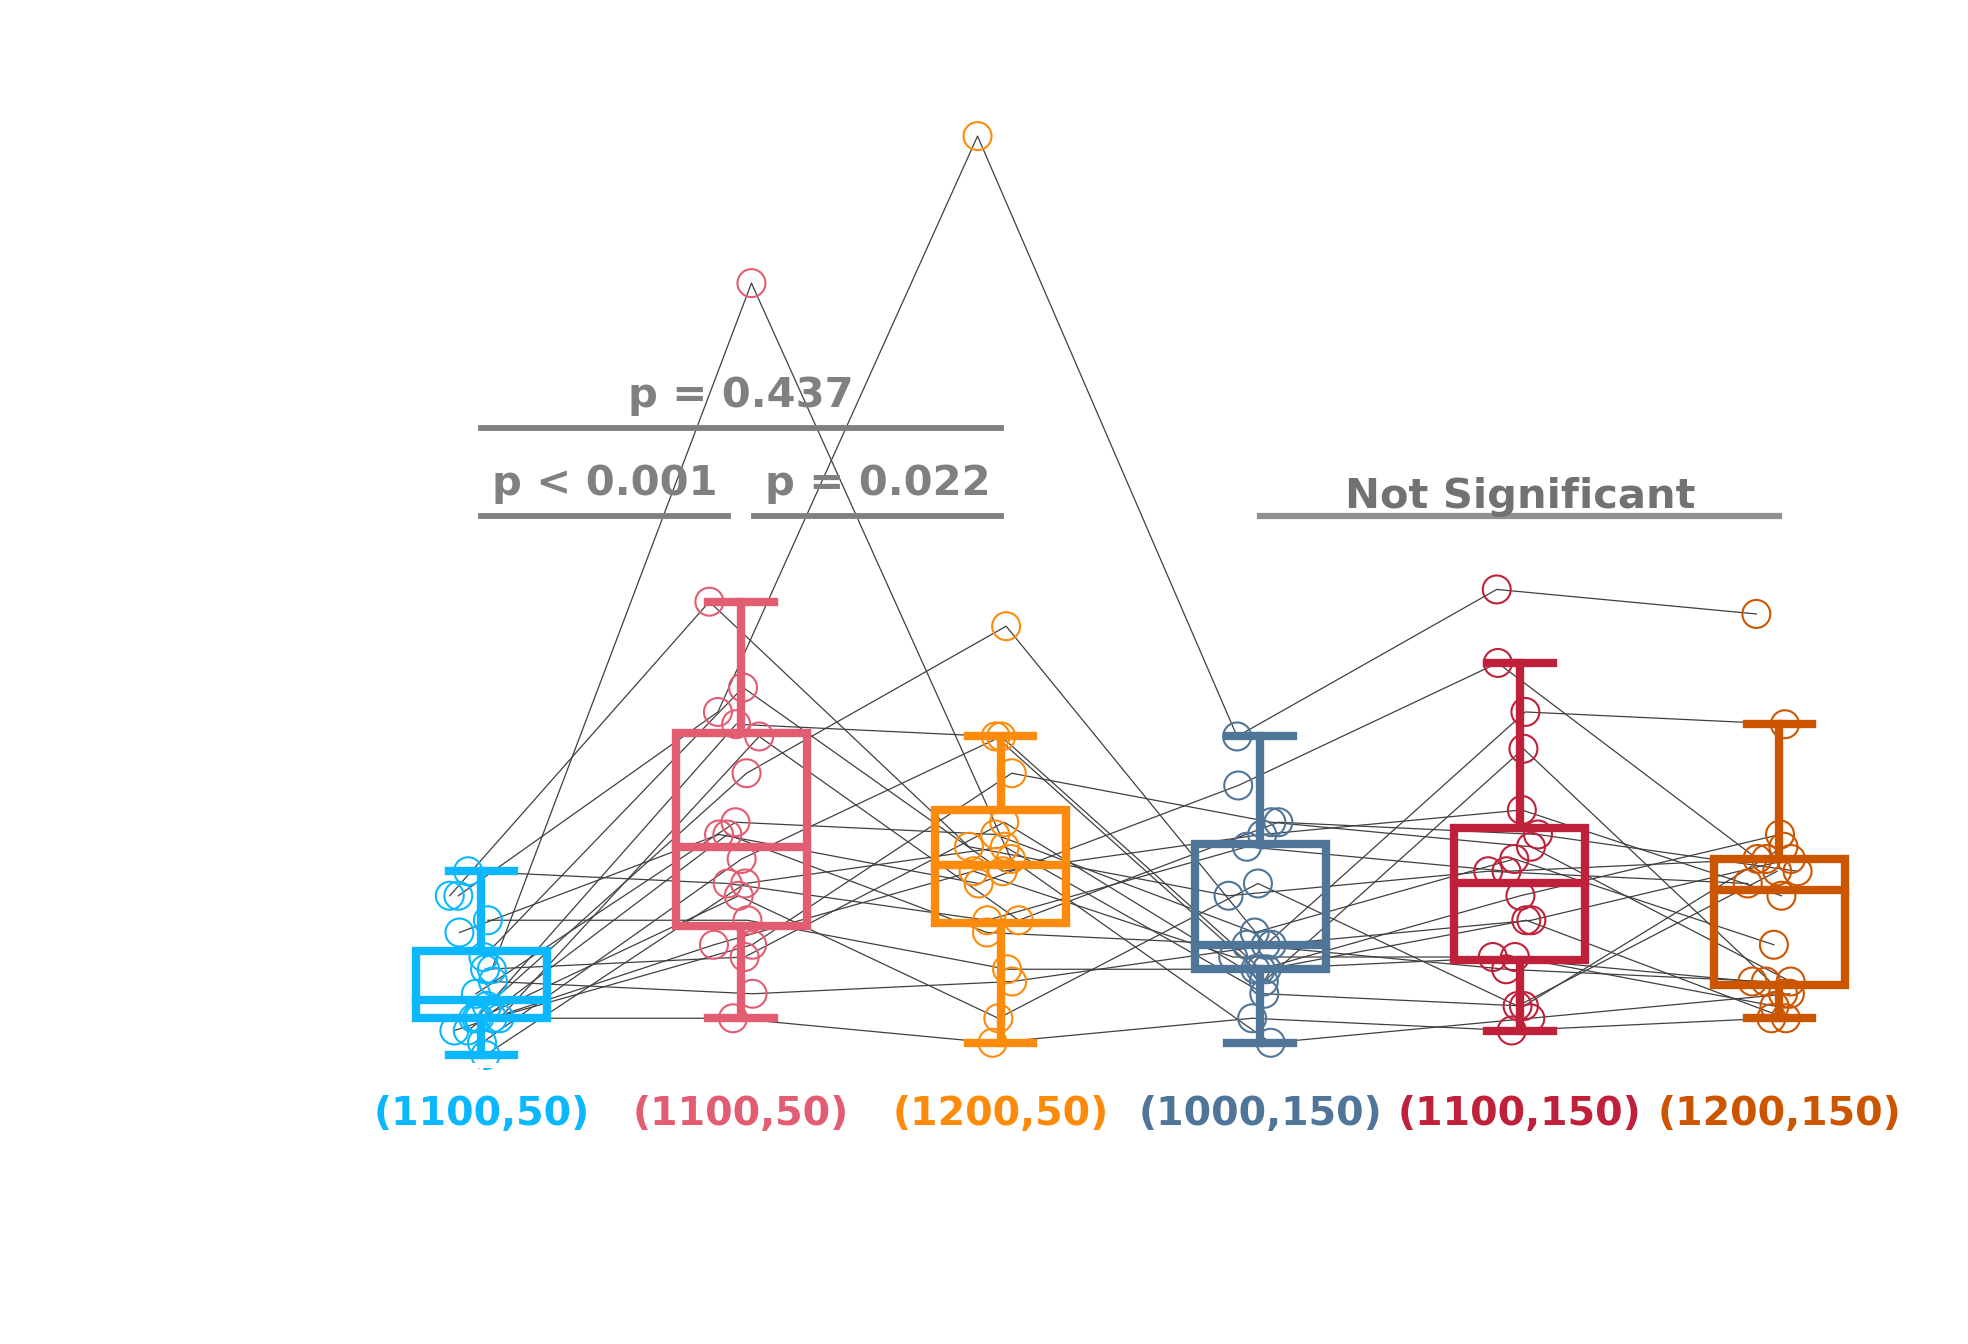

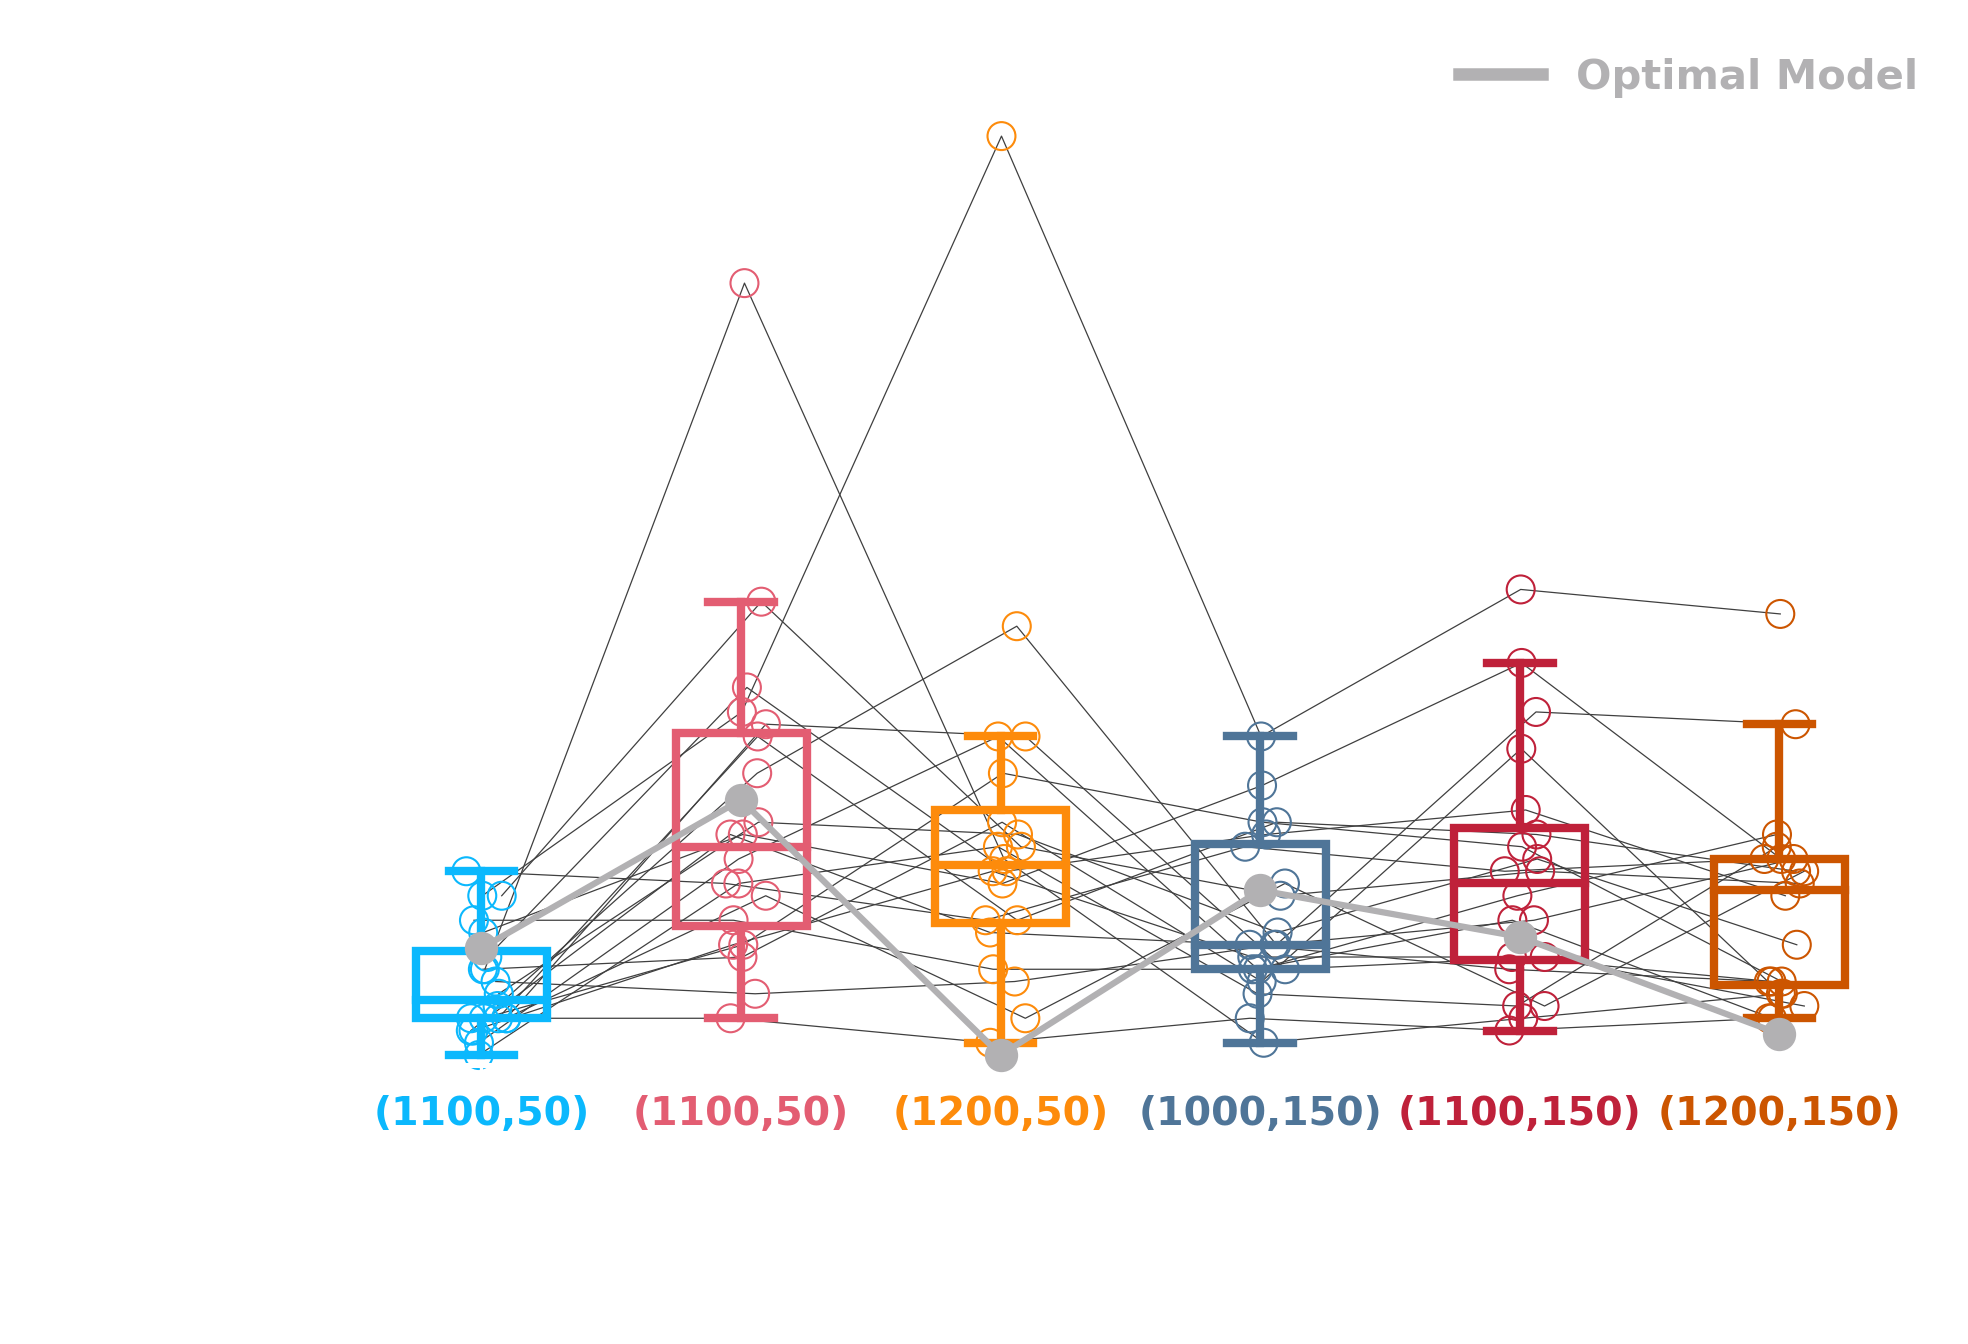

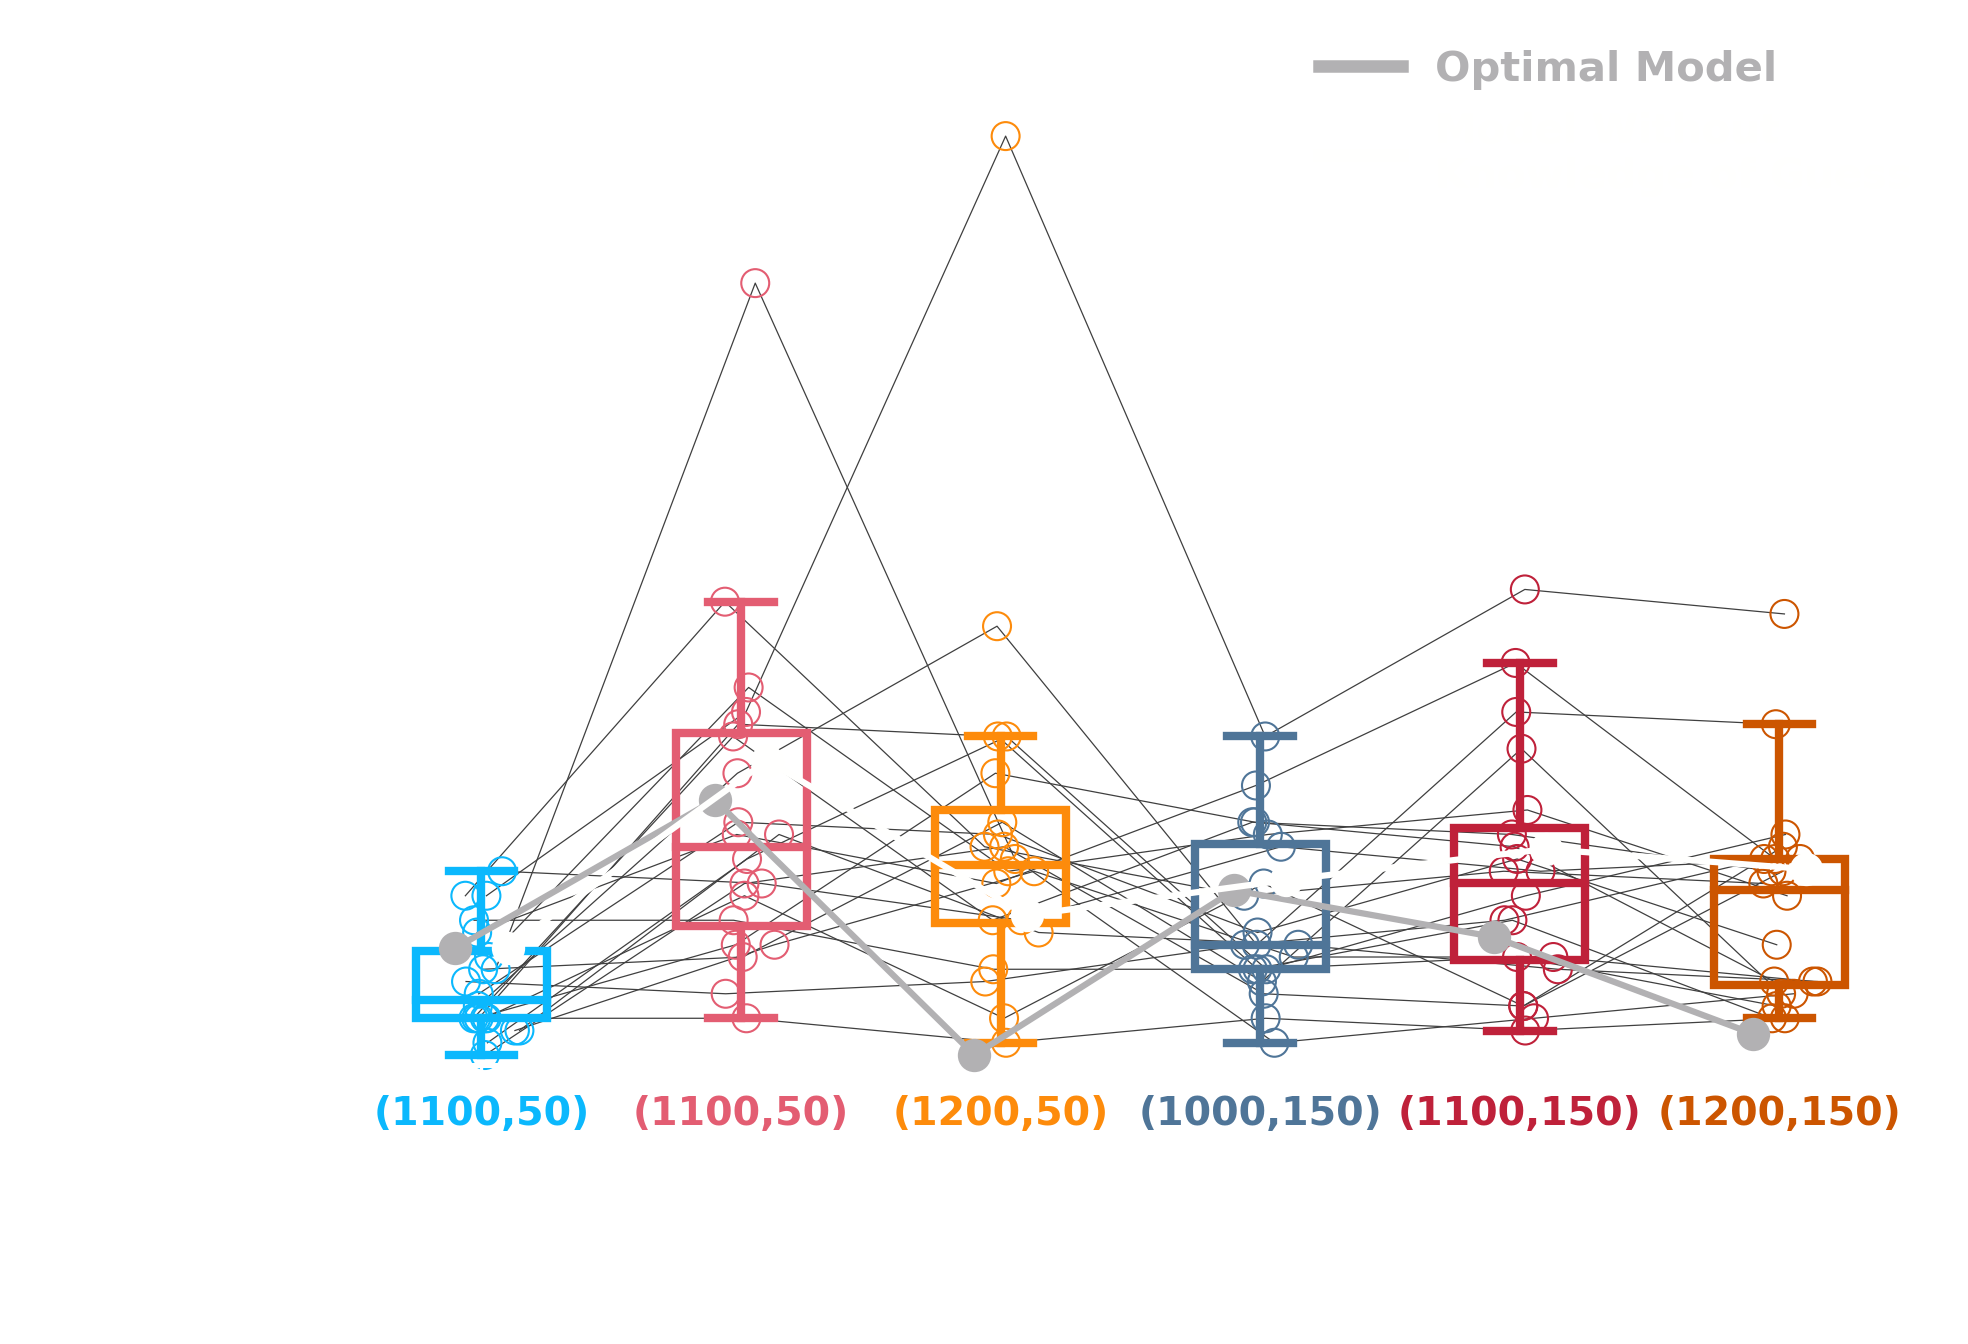

In [143]:
ylocs = np.arange(0, 101, 25)
ylabel = 'Indecisions (%)'
model_list = [
    [model.results.get_metric(model.score_metrics.prob_indecision*100,
    metric_type='true',decision_type='optimal') for key,model in models.items() if key == 'Theoretical Optimal'],
    [model.results.get_metric(model.score_metrics.prob_indecision*100,
    metric_type='true',decision_type='optimal') for model in models.values()],
]
model_labels = [['Optimal Model'], ['Optimal Model', 'Model Without\nKnowledge of Guess']]
legend_locs  = [(0.7,0.96), (0.61,0.86)]
# Loop 2
save_names = [
    ['only_model_optimal','only_model_both',],
    ['stats','stats'],
    ['data_and_model_optimal','data_and_model_both']
]
show_boxplots = [False, True, True]
show_models   = [True, False, True]
show_stats    = [False, True, False]
for i in range(len(save_names)):
    for j,model_data in enumerate(model_list):
        metric = st.df_to_array(df['Indecisions'],stats_inputs.num_subjects, stats_inputs.num_blocks)

        fig = dv.Figure(figsize=(w, h), dpi=300)
        ax = fig.add_panel(dim=(0.75, 0.1, 5.2, 3.3))
        pf.multiple_models_boxplot(
                ax=ax,
                data=metric,
                box_width = bw,
                model_data=model_data,
                show_boxplot=show_boxplots[i],
                show_models=show_models[i],
                reorder_xaxis = True,
                labels=model_labels[j],
                box_colors=[wheel.rak_blue, wheel.rak_red, wheel.rak_orange,wheel.dark_blue_hc,wheel.lighten_color(wheel.rak_red,1.5), wheel.burnt_orange,],
                line_colors = [wheel.lighten_color(wheel.light_grey,1), wheel.lighten_color(wheel.light_grey,0)],
                jitter_data = False,
                jitter = True,
                data_markersize=45,
                linestyles=None,
                xlocs=xlocs,
                # xtick_locs = np.linspace(1, w/div_w - 0.5, num=len(it.trial_block_titles)),
                ylocs=ylocs,
                xticklabels=it.trial_block_titles,
                xlabel=it.xlabel,
                ylabel=ylabel,
                legend_fontsize=legend_fontsize,
                legend_loc=legend_locs[j],
                model_markersize=7,
            )
        ax.set_ylim(-1,100)
        ax.set_xlim(-0.5,max(xlocs)+0.5)
        ax.xaxis.set_tick_params(labelsize=9.5)
        ax.yaxis.set_tick_params(labelsize=9.5)        
        # ax.spines.bottom.set_visible(False)
        # ax.tick_params(axis='x',bottom=False)
        ax.set_facecolor('none')

        if show_stats[i]:
            pf.plot_stats(
                ax,stats_inputs=stats_inputs, statistics=median_movement_onset_statistics,
                combos = ['02','24','04',],
                xpositions = [[xlocs[0],xlocs[1]-0.05], 
                            [xlocs[1]+0.05, xlocs[2]],
                            [xlocs[0],xlocs[2]]],
                ypos=[55,55,64,1420,1490],
                stacked=True,
                show_effectsize=False,
                lw = 1.4, 
                h = 1.3,
                fontsize=10,
                shorten_length=True
            )
            ax.plot((xlocs[3],xlocs[-1]),(55,55),color=wheel.grey)
            ax.text((xlocs[3]+xlocs[-1])/2, 57, 'Not Significant', color=wheel.dark_grey, ha = 'center', va='center',fontweight='bold')
        plt.show()
        fig.savefig(SAVE_PATH / f'movement_onset_times_{save_names[i][j]}')
        # Don't need to run two models if we're doing stats
        if save_names[i] == 'stats':
            break

## SD Movement Onset

### Stats

In [116]:
sd_movement_onset_anova = st.Anova('SD_Movement_Onset_Time', stats_inputs)
display(sd_movement_onset_anova.anova)
sd_movement_onset_boot = st.Bootstrap(stats_inputs, sd_movement_onset_anova,no_collapse=True,
                                          alternative='two-sided',test='median')
sd_movement_onset_statistics = sd_movement_onset_boot.run_bootstrap()
sd_movement_onset_statistics

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,Factor_1,15203.650706,2,38,7601.825353,5.501936,0.007971,0.018015,0.041648,0.691673
1,Factor_2,10047.983589,1,19,10047.983589,20.361034,0.000238,0.000238,0.027919,1.000000
2,Factor_1 * Factor_2,3851.588749,2,38,1925.794374,2.485900,0.096694,0.097401,0.010889,0.988805


Significant interaction, doing pairwise bootstraps for each condition...


[{'02': 0.009072,
  '04': 0.00018600000000000002,
  '13': 0.500414,
  '15': 0.500414,
  '24': 0.006024999999999999,
  '35': 0.162939},
 {'02': 65.0, '04': 90.0, '13': 60.0, '15': 65.0, '24': 80.0, '35': 60.0}]

### Plot

NameError: name 'title_fontsize' is not defined

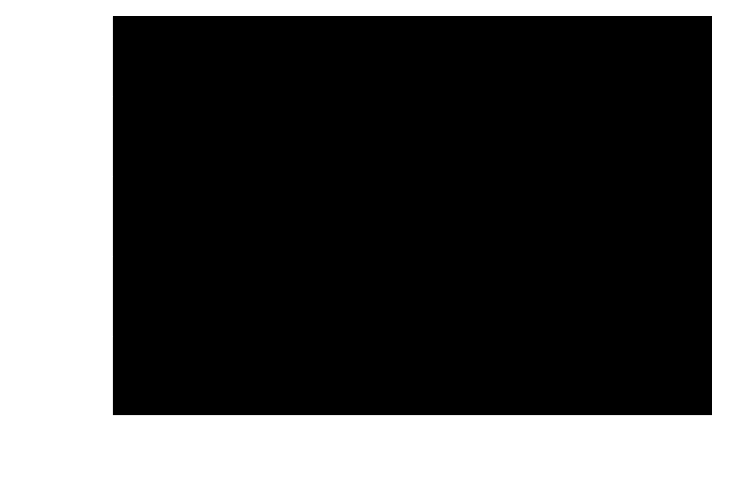

In [117]:


if True:
    metric = st.df_to_array(df['SD_Movement_Onset_Time'],stats_inputs.num_subjects, stats_inputs.num_blocks)
    ylocs = np.arange(0, 400, 50)
    ylabel = 'Time (ms)'
    title = 'SD Movement Onset Time' 

    fig = dv.Figure(figsize=(w, h), dpi=110)
    ax = fig.add_panel(dim=(0.6, 0, w / div_w, h / div_h))
    model_data = [model.results.get_metric(model.player_behavior.wtd_leave_time_sd,
                                           metric_type='true',decision_type='optimal') for model in models.values()]
    pf.multiple_models_boxplot(
            ax=ax,
            data=metric,
            box_width = bw,
            model_data=model_data,
            show_boxplot=SHOW_BOXPLOTS,
            show_models=SHOW_MODELS,
            reorder_xaxis = True,
            labels=['Theoretical Optimal', 'Not Accounting for\nGuess Uncertainty'],
            colors=wheel.grey,
            linestyles=None,
            line_colors = [wheel.yellow, wheel.rak_blue],
            xlocs=xlocs,
            # xtick_locs = np.linspace(1, w/div_w - 0.5, num=len(it.trial_block_titles)),
            ylocs=ylocs,
            xticklabels=it.trial_block_titles,
            xlabel=it.xlabel,
            ylabel=ylabel,
            title=title,
            legend_fontsize=legend_fontsize,
            legend_loc='lower right',
            title_fontsize=title_fontsize,
            title_padding=40,
        )
    ax.set_ylim(0,350)
    ax.set_xlim(-1,max(xlocs)+1)
    if SHOW_STATS:
        pf.plot_stats(ax,stats_inputs=stats_inputs, statistics=sd_movement_onset_statistics,
                    combos = ['02','04','24'],xlocs=xlocs, 
                    xloc_index = ['01','02','12'], 
                    ypos=[230,270,250,],
                    fontsize=18,stacked=True,
                    show_effectsize=False,
                        )
    
    fig.remove_figure_borders()
print(bw)